In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet
import cvxpy as cvx

Датафрейм returns - это таблица доходностей, то есть $\frac{p_{new} - p_{old}}{p_{old}}$.

In [210]:
returns = pd.read_csv('work/data/returns.csv')
returns = returns.fillna(0)
returns['date'] = returns['date'].astype(np.datetime64)
returns = returns.set_index('date')
returns

MPWR       CCI       ESS         D       MRK       LYB  \
date                                                                     
2012-01-03  0.008617  0.002673 -0.001422 -0.010919  0.015902  0.030153   
2012-01-04 -0.022360  0.002232 -0.016461 -0.008197  0.001041  0.037907   
2012-01-05  0.022867 -0.000896  0.018621 -0.002108  0.010437 -0.014373   
2012-01-06  0.000000  0.001563 -0.004206 -0.010198 -0.006946  0.006150   
2012-01-09  0.026294  0.012886 -0.003637 -0.001366 -0.002110 -0.003796   
...              ...       ...       ...       ...       ...       ...   
2021-04-26  0.022948 -0.005771 -0.001548 -0.008816 -0.004498  0.005077   
2021-04-27 -0.011632 -0.007309  0.000539 -0.004958 -0.002191 -0.000279   
2021-04-28 -0.019426  0.002436 -0.033900 -0.008295 -0.003492  0.013819   
2021-04-29 -0.016980  0.014958 -0.002789  0.017766 -0.044237  0.010624   
2021-04-30 -0.026216  0.005855  0.015202  0.011138  0.011125 -0.034893   

                 MLM       CAG       XEL       AMG  ...        FL      ZBRA  \
date                                                ...                       
2012-01-03  0.004373 -0.004202 -0.010835  0.016249  ...  0.006281 -0.001677   
2012-01-04 -0.000397  0.008374 -0.006582  0.002974  ...  0.005409 -0.007558   
2012-01-05  0.002369 -0.000761  0.004399  0.004400  ...  0.025710 -0.001410   
2012-01-06 -0.022404 -0.002664 -0.002921 -0.002133  ...  0.008877 -0.008192   
2012-01-09  0.009040  0.003818  0.000757  0.020093  ...  0.002800 -0.004558   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-26  0.018957 -0.010897 -0.006742 -0.000316  ... -0.033187  0.002192   
2021-04-27  0.000361 -0.003772 -0.008512  0.018091  ...  0.028386  0.006521   
2021-04-28 -0.006794 -0.001893 -0.002703 -0.009009  ...  0.002375 -0.010264   
2021-04-29  0.010980  0.006626  0.010743  0.028092  ...  0.003905  0.000060   
2021-04-30 -0.016571  0.003523  0.010486 -0.017136  ... -0.001851 -0.017904   

                 THC        BR      EVRG      URBN       ANF       TIE  \
date                                                                     
2012-01-03 -0.033134  0.005345  0.000000  0.006894  0.001017  0.040086   
2012-01-04 -0.054445 -0.002685  0.000000  0.023784 -0.033332 -0.007093   
2012-01-05  0.014928  0.003554  0.000000 -0.015134 -0.028995 -0.019374   
2012-01-06  0.048315 -0.005259  0.000000 -0.011080 -0.021353  0.011868   
2012-01-09  0.022043  0.007499  0.000000  0.040108  0.016019  0.005198   
...              ...       ...       ...       ...       ...       ...   
2021-04-26  0.003232 -0.009898  0.000794 -0.056878 -0.041292  0.000000   
2021-04-27  0.010379  0.001303 -0.009923  0.034706  0.026156  0.000000   
2021-04-28  0.043925 -0.001363  0.005725  0.000798 -0.000515  0.000000   
2021-04-29  0.011027  0.002793  0.002679 -0.022610 -0.028854  0.000000   
2021-04-30 -0.005537 -0.017531  0.008522 -0.023133 -0.005570  0.000000   

                INTU       SPY  
date                            
2012-01-03 -0.002469  0.015934  
2012-01-04 -0.003043  0.001568  
2012-01-05  0.004588  0.002663  
2012-01-06  0.013890 -0.002577  
2012-01-09  0.001137  0.002427  
...              ...       ...  
2021-04-26  0.008123  0.002088  
2021-04-27 -0.005189 -0.000216  
2021-04-28 -0.000768 -0.000287  
2021-04-29  0.000840  0.006372  
2021-04-30 -0.009589 -0.006569  

[2347 rows x 611 columns]

In [211]:
def decrease_risk(mu, Sigma, R):
    p = len(mu)
    w = cvx.Variable(p)
    obj = cvx.Minimize(1/2 * cvx.quad_form(w, Sigma))
    
    equal_constraints_1 = [mu.T @ w == R]
    equal_constraints_2 = [np.ones(p) @ w == 1]
    eyes = np.eye(p)
    nonequal_constraints = [eye @ w >= 0 for eye in eyes]
    constraints = equal_constraints_1 + equal_constraints_2 + nonequal_constraints
    
    problem = cvx.Problem(obj, constraints=constraints)
    result = problem.solve(verbose=True, solver="SCS")
    
    opt_weights = w.value
    return opt_weights

In [212]:
train_size = 1500

returns_train = returns[:train_size]
returns_test = returns[train_size:]

In [288]:
num_of_companies = 20

mean = returns_train[returns_train.columns].mean()
top_returns = returns_train[mean.sort_values(ascending=False)[:num_of_companies].index]
top_returns.columns

Index(['NFLX', 'TSLA', 'NKTR', 'NVDA', 'ABMD', 'STZ', 'ALGN', 'AVGO', 'INCY',
       'ILMN', 'MU', 'NXPI', 'TTWO', 'DXCM', 'REGN', 'MPWR', 'DAL', 'LUV',
       'CSC', 'VRTX'],
      dtype='object')

In [214]:
mu = mean.sort_values(ascending=False)[:num_of_companies].to_numpy()
mu[:5], mu.shape

(array([0.00248749, 0.00212164, 0.00211797, 0.00203331, 0.00193894]), (20,))

In [215]:
R = 2e-3
Sigma = top_returns[top_returns.columns].cov()
Sigma[['NFLX', 'TSLA', 'NKTR', 'NVDA', 'ABMD']][:5]

NFLX      TSLA      NKTR      NVDA      ABMD
NFLX  0.001069  0.000230  0.000156  0.000146  0.000121
TSLA  0.000230  0.000934  0.000200  0.000138  0.000113
NKTR  0.000156  0.000200  0.001174  0.000169  0.000161
NVDA  0.000146  0.000138  0.000169  0.000476  0.000117
ABMD  0.000121  0.000113  0.000161  0.000117  0.000763

In [216]:
w_no_opt = decrease_risk(mu, Sigma, R)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:05:20 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:05:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:05:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:05:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:05:20 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:05:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [217]:
def count_portfolio_return(colums, weights, test):
    portfolio_return = 0
    for w, col in zip(weights, columns):
        one_company_return = w * (test[col] + 1).cumprod()
        portfolio_return += one_company_return
    return portfolio_return

In [218]:
columns = top_returns.columns.to_numpy()
portfolio_return_no_opt = count_portfolio_return(columns, w_no_opt, returns_test)
portfolio_return_no_opt

date
2017-12-18    1.005896
2017-12-19    1.001772
2017-12-20    1.004200
2017-12-21    0.997490
2017-12-22    0.998036
                ...   
2021-04-26    2.856109
2021-04-27    2.800665
2021-04-28    2.784579
2021-04-29    2.752533
2021-04-30    2.779777
Name: NFLX, Length: 847, dtype: float64

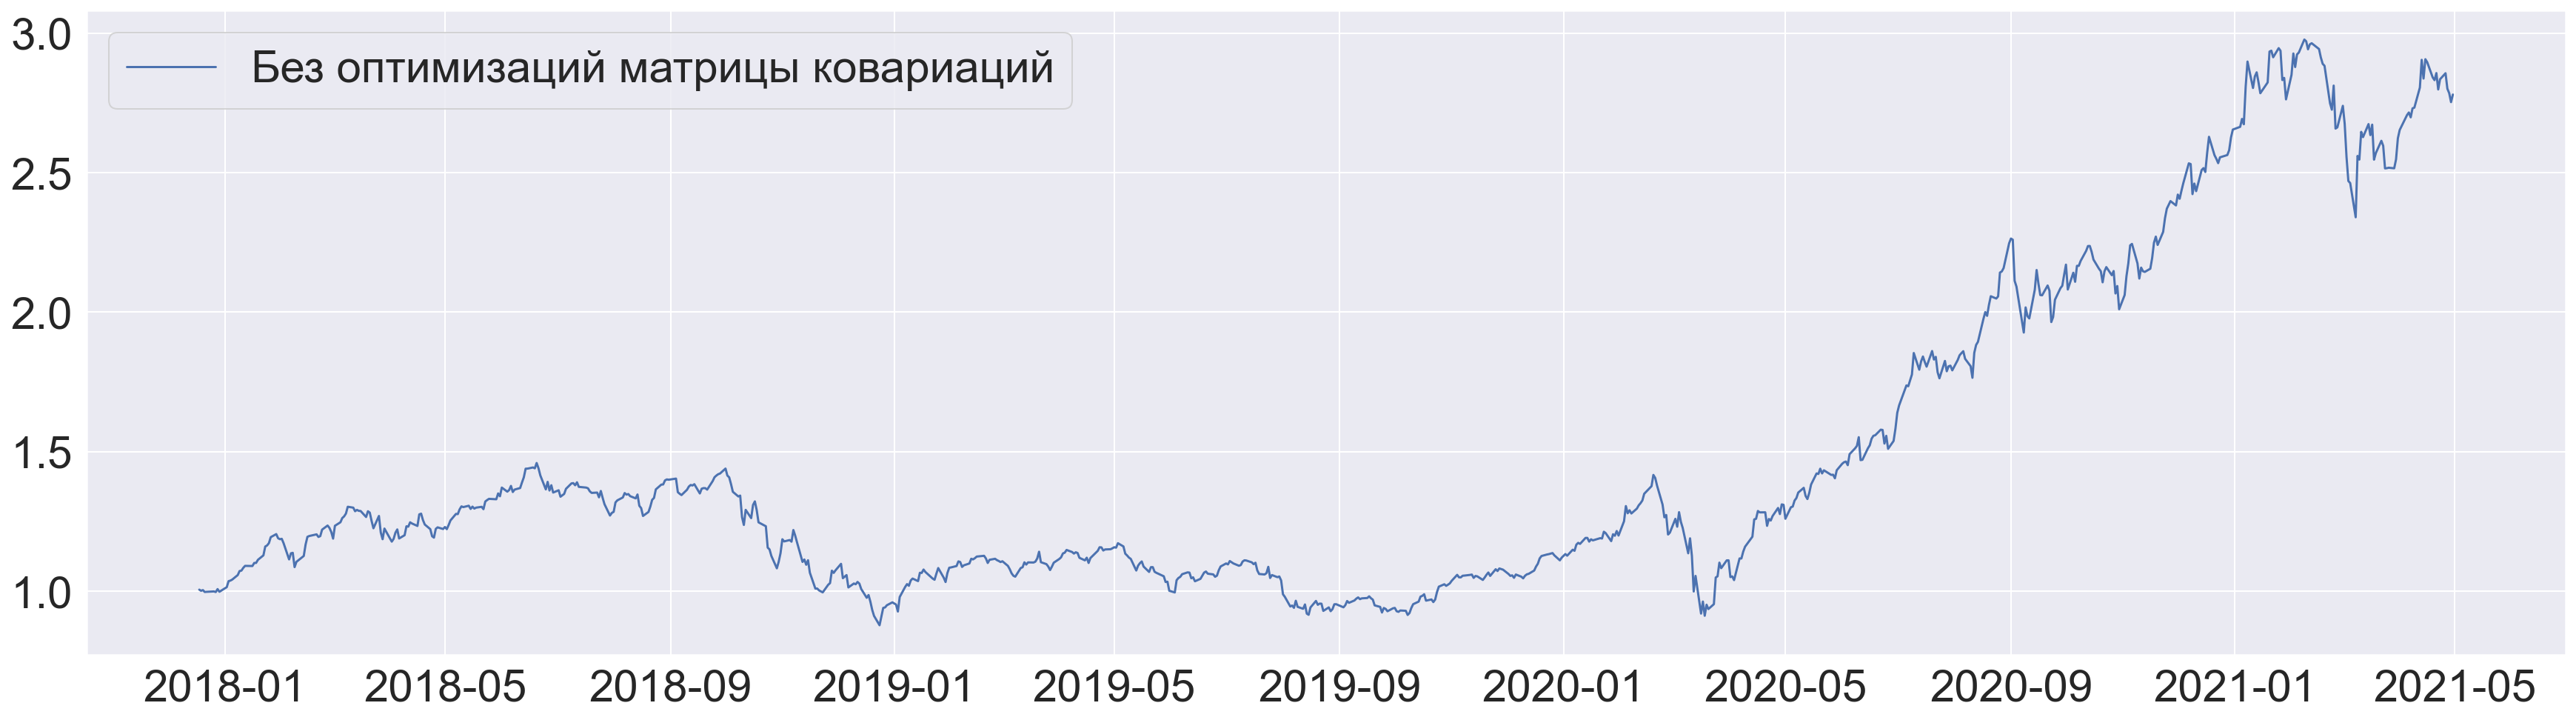

In [219]:
plt.figure(figsize=(30, 8))
#plt.yscale('log')

plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

Попробуем применить PCA к исходным данным.

In [220]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

data = np.array([[1, 0],
                 [0, 1], 
                 [1, 1]])
pca.fit(data)
pca.inverse_transform(pca.transform(data))
pca.components_

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

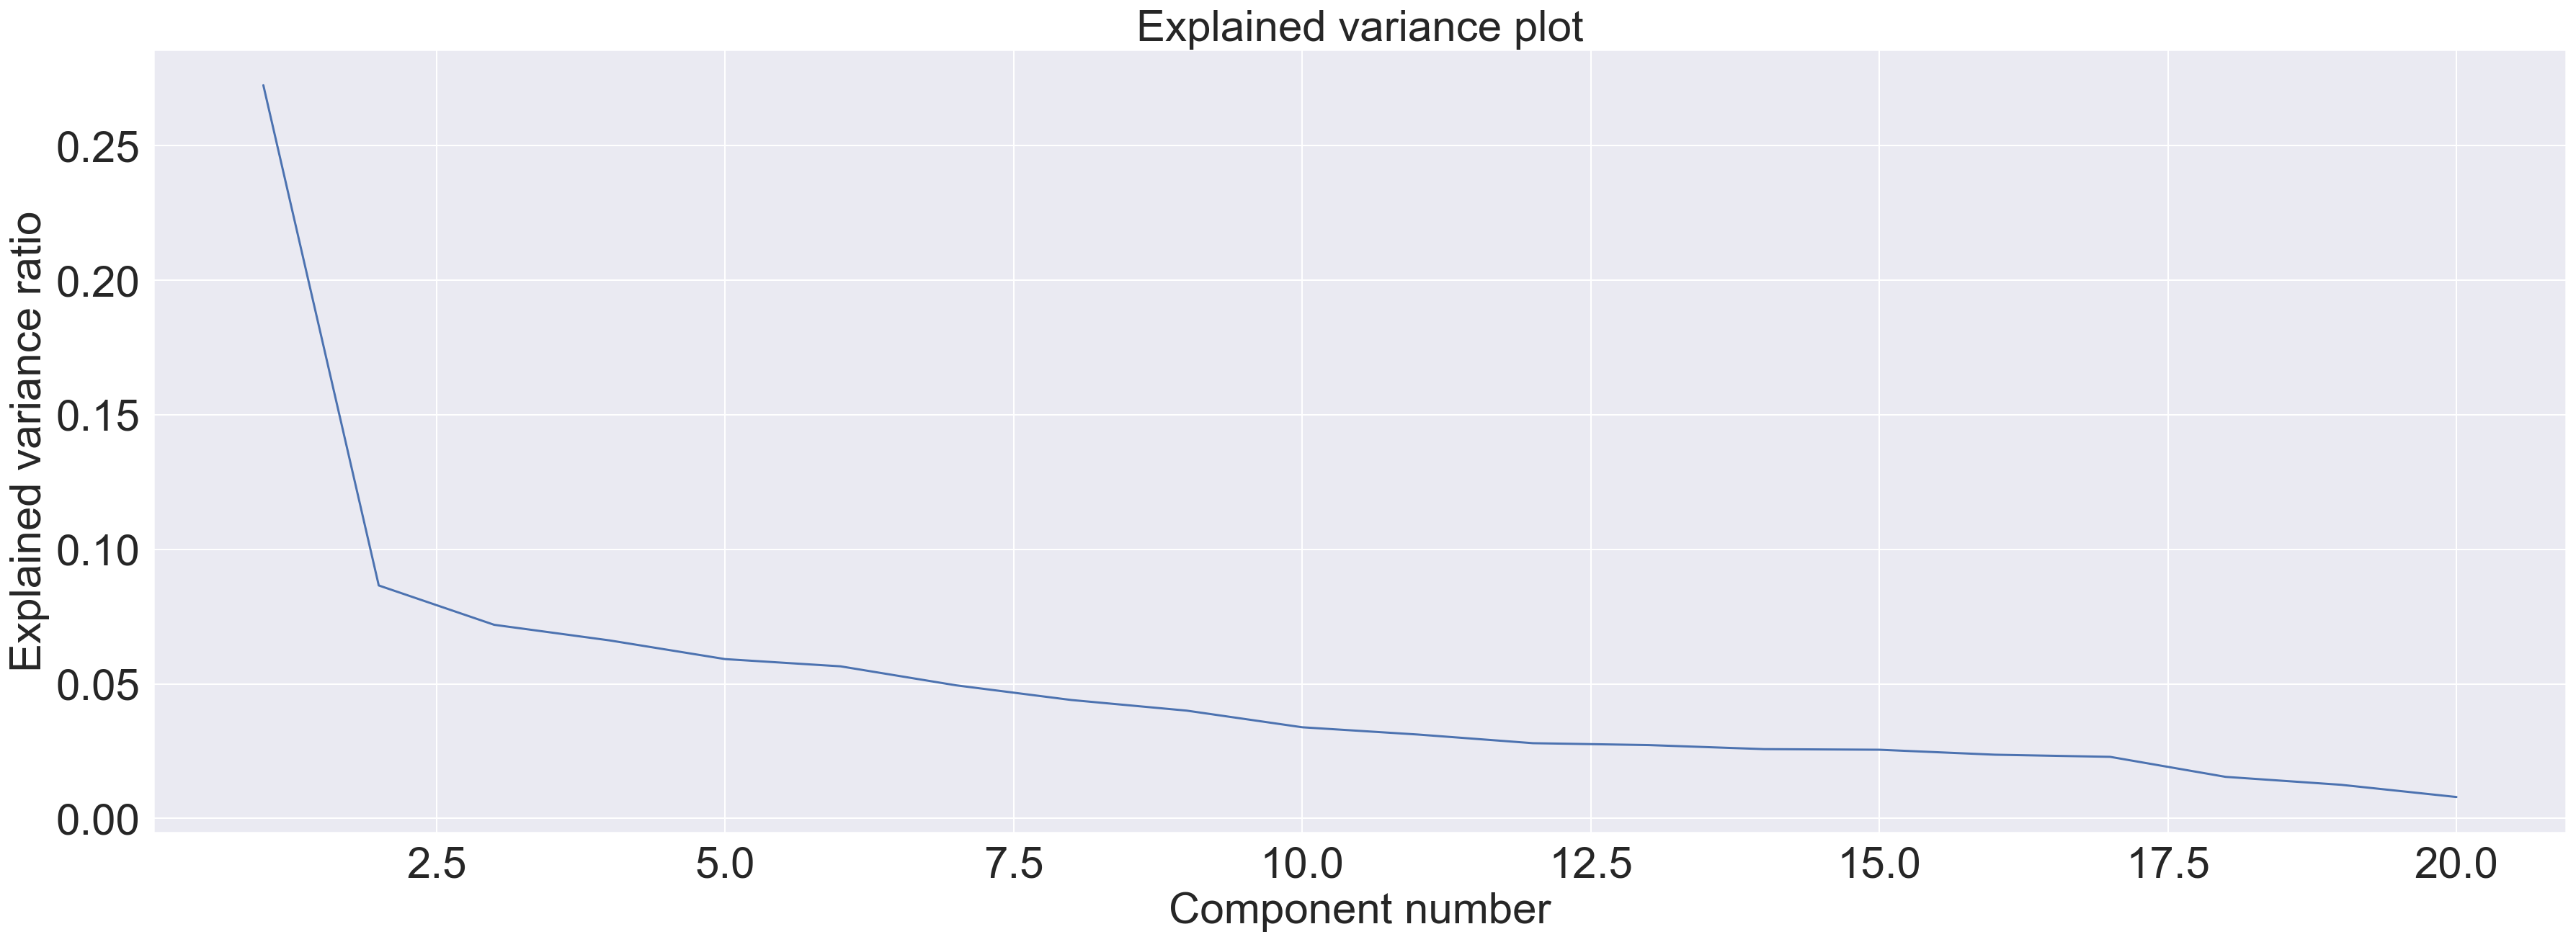

In [221]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(top_returns)

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title("Explained variance plot")
ax.set_xlabel("Component number")
ax.set_ylabel("Explained variance ratio")
plt.plot(np.arange(pca.n_components) + 1, pca.explained_variance_ratio_);

In [222]:
transformed_top_returns = pca.transform(top_returns)
transformed_top_returns.shape

(1500, 20)

In [223]:
kept_components = 8
transformed_top_returns[:,kept_components:] = 0
transformed_top_returns.shape

(1500, 20)

In [224]:
simplified_returns = pca.inverse_transform(transformed_top_returns)
simplified_returns.shape

(1500, 20)

In [225]:
mu = np.mean(simplified_returns, axis=0)

R = 2e-3
Sigma = np.cov(simplified_returns.T)

w_8 = decrease_risk(mu, Sigma, R)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:05:22 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:05:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:05:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:05:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:05:22 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:05:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [226]:
w_8, len(w_8), np.sum(w_8)

(array([ 1.61036478e-01,  4.95939709e-02,  3.01111574e-02,  3.18299529e-01,
        -5.61605353e-06,  4.41133189e-01, -8.75878332e-06, -8.95567701e-06,
        -1.06749432e-05, -1.17025152e-05, -1.08286399e-05, -1.16227894e-05,
        -1.19134982e-05, -1.24954963e-05, -1.25567036e-05, -1.28344082e-05,
        -1.36846853e-05, -1.40910959e-05, -1.40238893e-05, -1.43567303e-05]),
 20,
 1.0000002090094433)

In [227]:
columns = top_returns.columns.to_numpy()
portfolio_return_8 = count_portfolio_return(columns, w_8, returns_test)
portfolio_return_8

date
2017-12-18    1.006156
2017-12-19    1.000848
2017-12-20    1.004202
2017-12-21    1.004811
2017-12-22    1.002713
                ...   
2021-04-26    2.505430
2021-04-27    2.470312
2021-04-28    2.455788
2021-04-29    2.456097
2021-04-30    2.459285
Name: NFLX, Length: 847, dtype: float64

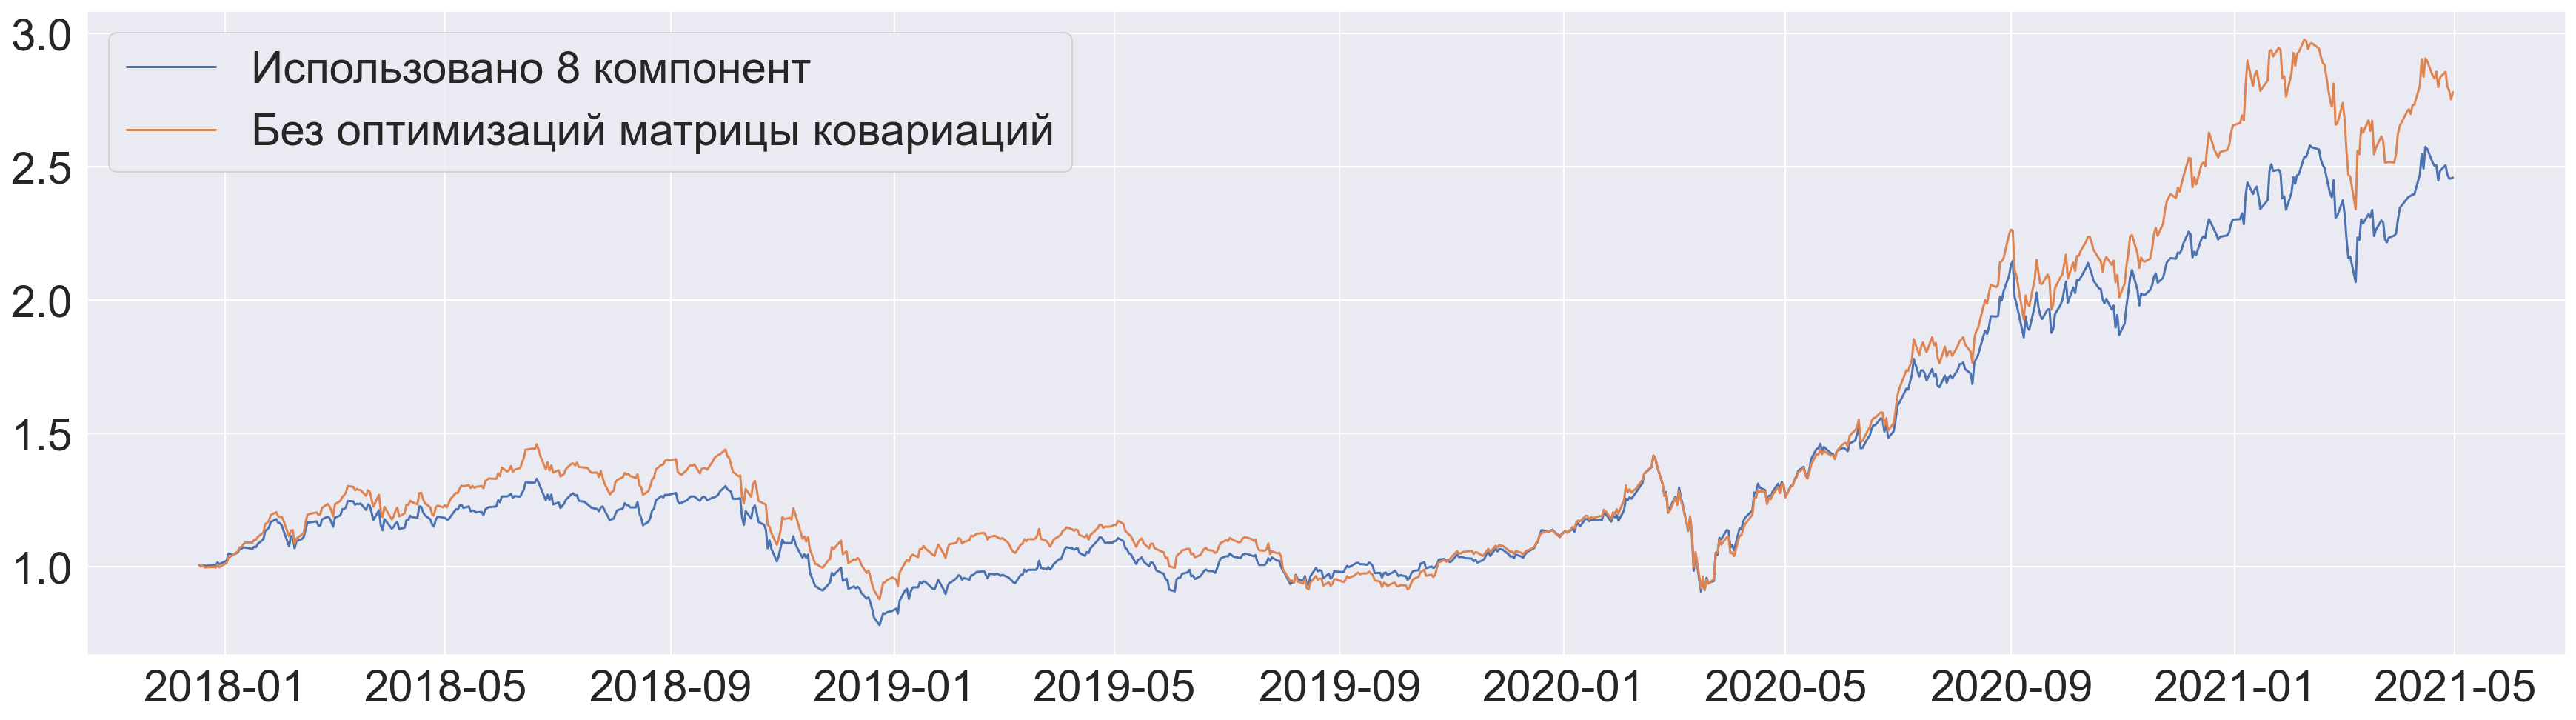

In [228]:
plt.figure(figsize=(30, 8))

plt.plot(portfolio_return_8.index, portfolio_return_8, label='Использовано 8 компонент')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

In [229]:
transformed_top_returns = pca.transform(top_returns)

kept_components = 3
transformed_top_returns[:,kept_components:] = 0

simplified_returns = pca.inverse_transform(transformed_top_returns)

mu = np.mean(simplified_returns, axis=0)

R = 2e-3
Sigma = np.cov(simplified_returns.T)

w_3 = decrease_risk(mu, Sigma, R)

columns = top_returns.columns.to_numpy()
portfolio_return_3 = count_portfolio_return(columns, w_3, returns_test)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:05:23 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:05:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:05:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:05:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:05:23 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:05:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [230]:
transformed_top_returns = pca.transform(top_returns)

kept_components = 12
transformed_top_returns[:,kept_components:] = 0

simplified_returns = pca.inverse_transform(transformed_top_returns)

mu = np.mean(top_returns.to_numpy(), axis=0)

R = 2e-3
Sigma = np.cov(simplified_returns.T)

w_12 = decrease_risk(mu, Sigma, R)

columns = top_returns.columns.to_numpy()
portfolio_return_12 = count_portfolio_return(columns, w_12, returns_test)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:05:23 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:05:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:05:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:05:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:05:23 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:05:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [231]:
transformed_top_returns = pca.transform(top_returns)

kept_components = 5
transformed_top_returns[:,kept_components:] = 0

simplified_returns = pca.inverse_transform(transformed_top_returns)

mu = np.mean(top_returns.to_numpy(), axis=0)

R = 2e-3
Sigma = np.cov(simplified_returns.T)

w_5 = decrease_risk(mu, Sigma, R)

columns = top_returns.columns.to_numpy()
portfolio_return_5 = count_portfolio_return(columns, w_5, returns_test)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:05:23 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:05:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:05:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:05:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:05:23 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:05:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [232]:
np.mean(top_returns.to_numpy(), axis=0)

array([0.00248749, 0.00212164, 0.00211797, 0.00203331, 0.00193894,
       0.00177612, 0.00176269, 0.00174744, 0.00168993, 0.00163993,
       0.00163726, 0.00162181, 0.00162123, 0.00160102, 0.00158497,
       0.00156813, 0.00154842, 0.0015262 , 0.00152034, 0.00150349])

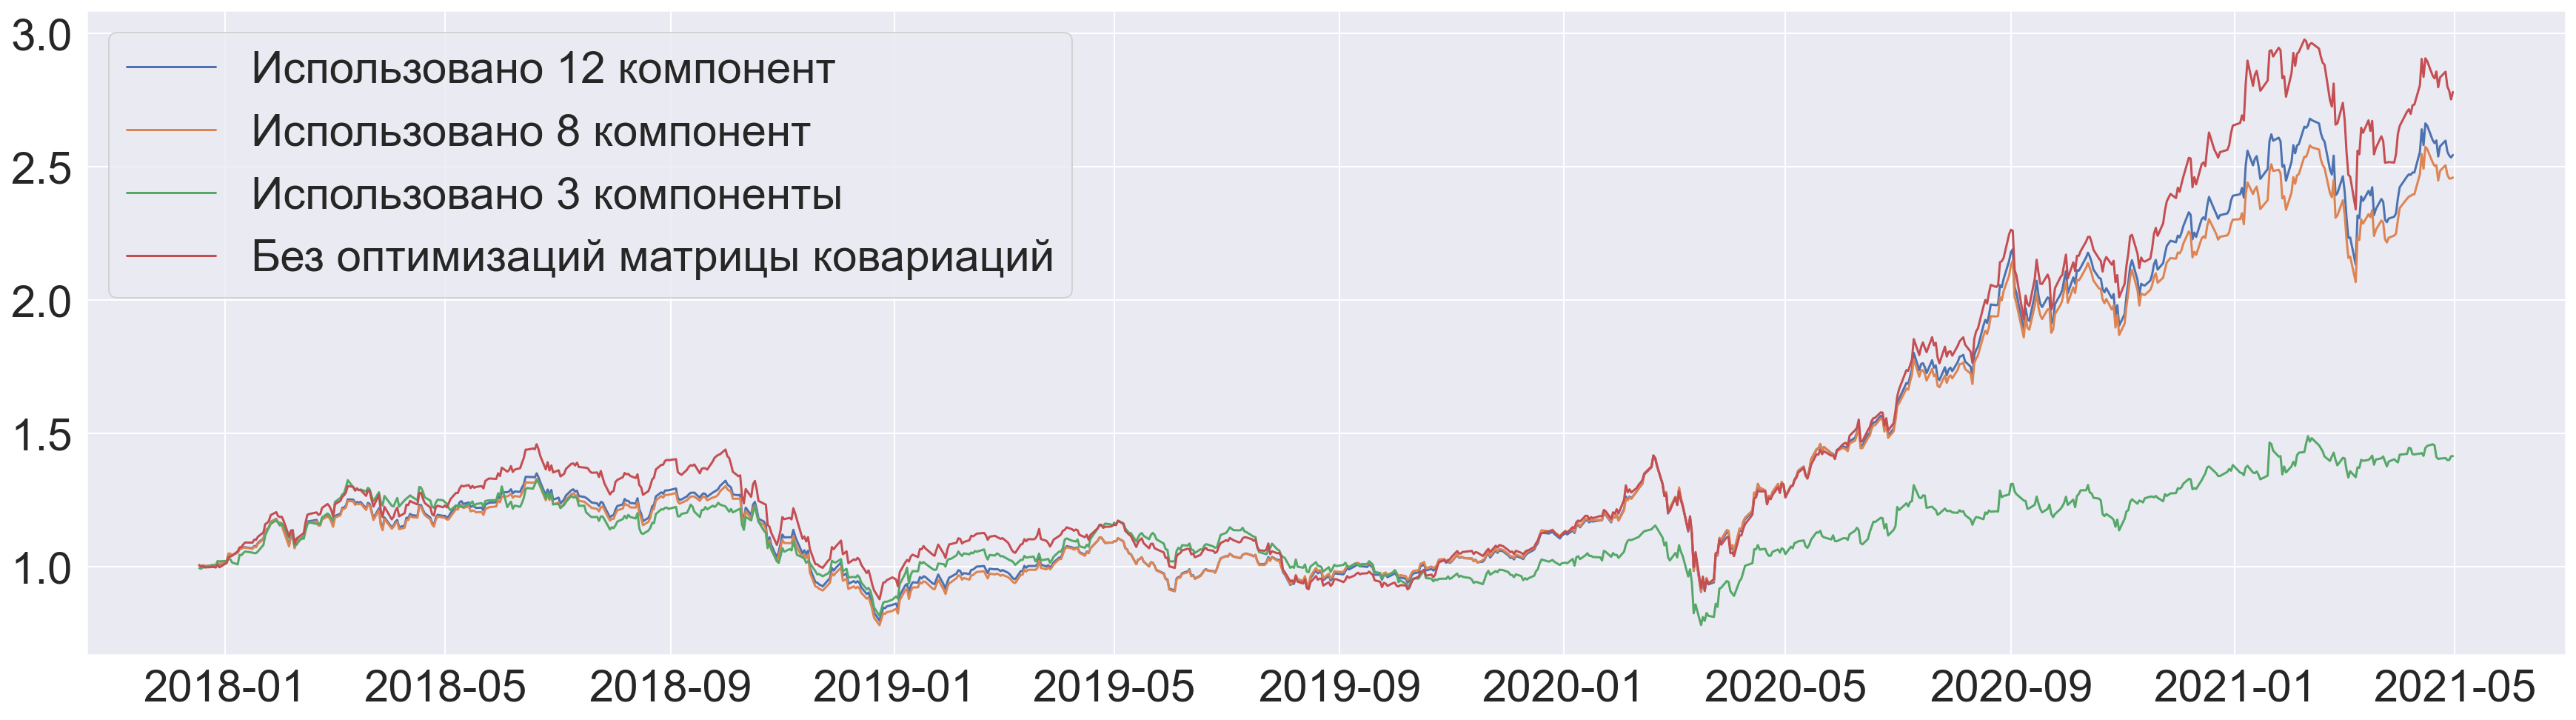

In [233]:
plt.figure(figsize=(30, 8))

plt.plot(portfolio_return_12.index, portfolio_return_12, label='Использовано 12 компонент')
plt.plot(portfolio_return_8.index, portfolio_return_8, label='Использовано 8 компонент')
plt.plot(portfolio_return_3.index, portfolio_return_3, label='Использовано 3 компоненты')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

Поиграемся с данными немного.

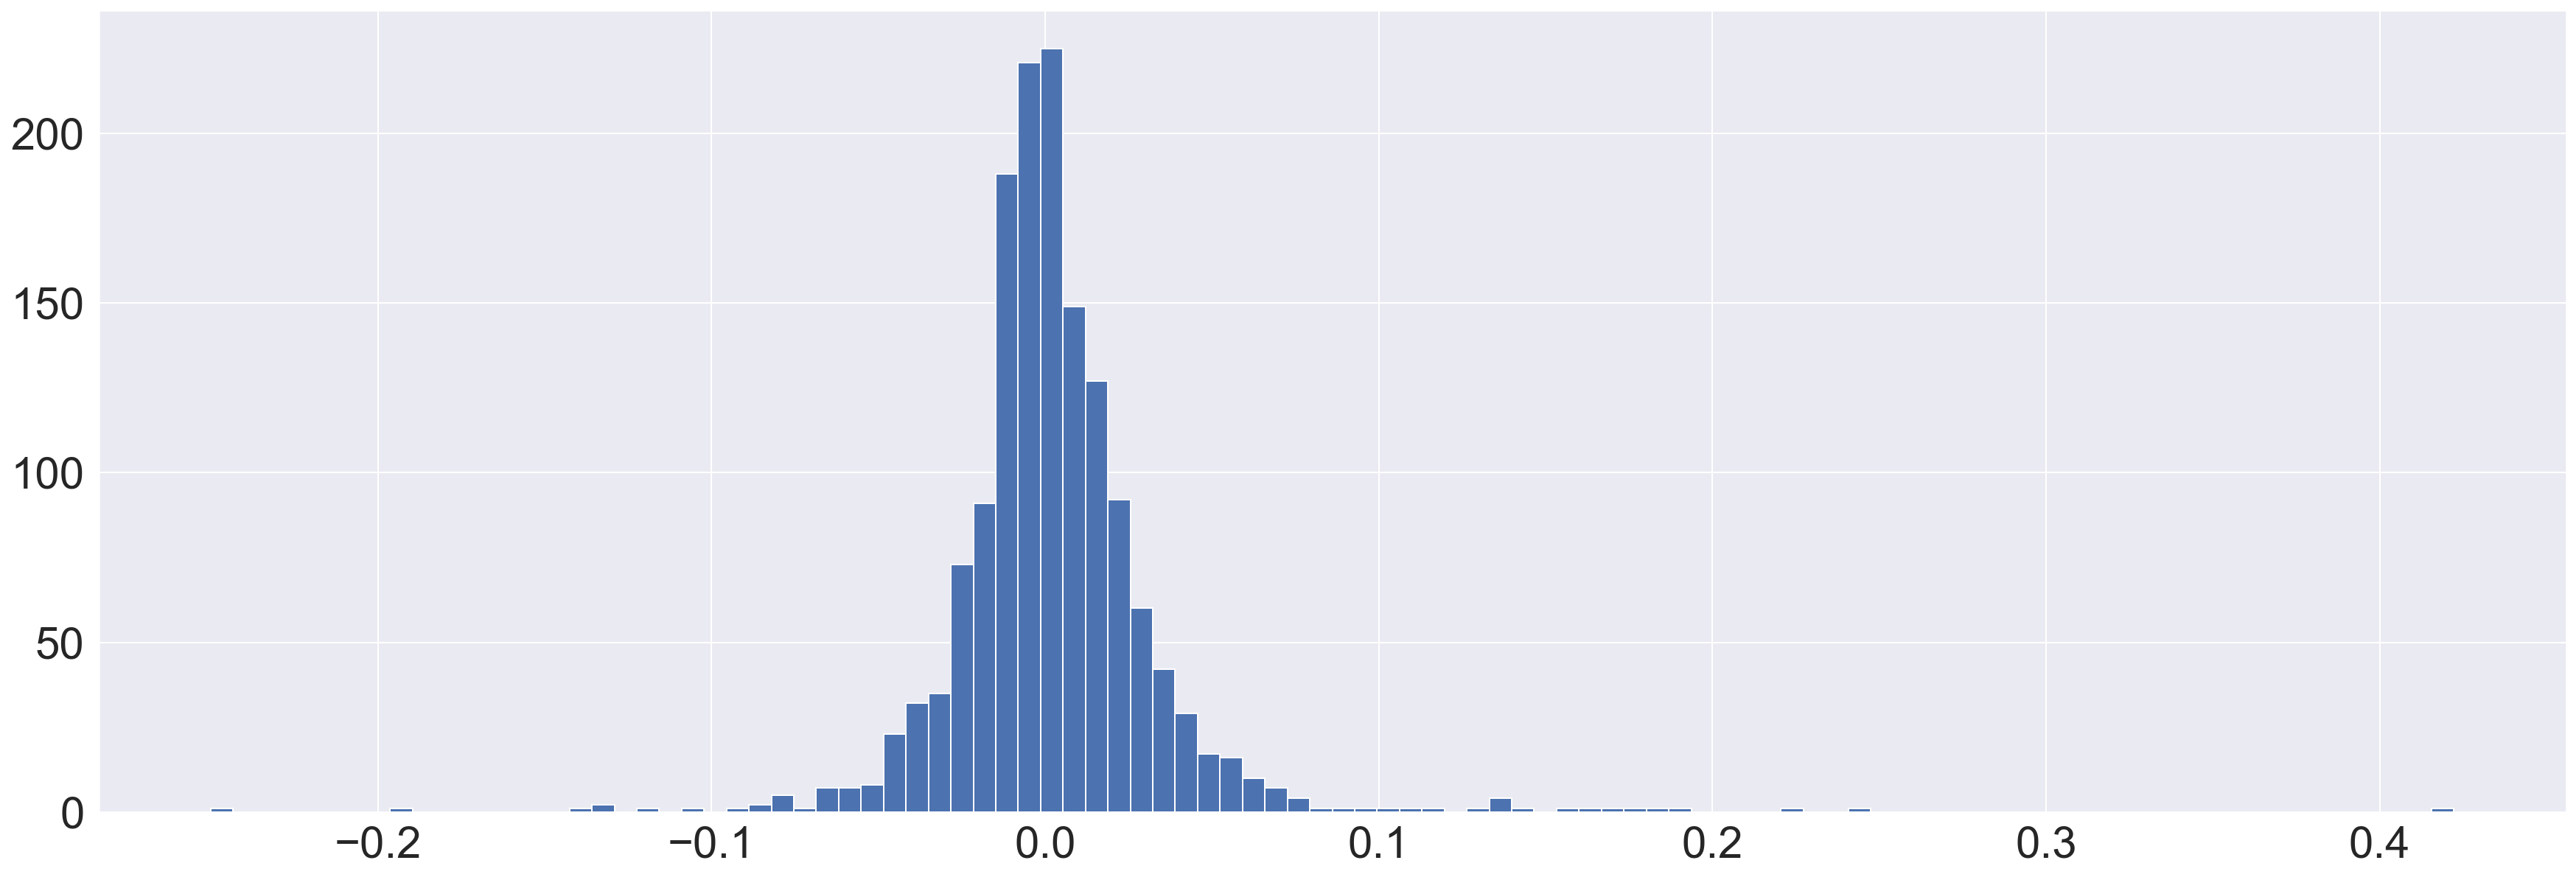

In [234]:
plt.figure(figsize=(30, 10))
plt.hist(top_returns['NFLX'].to_numpy(), bins=100);

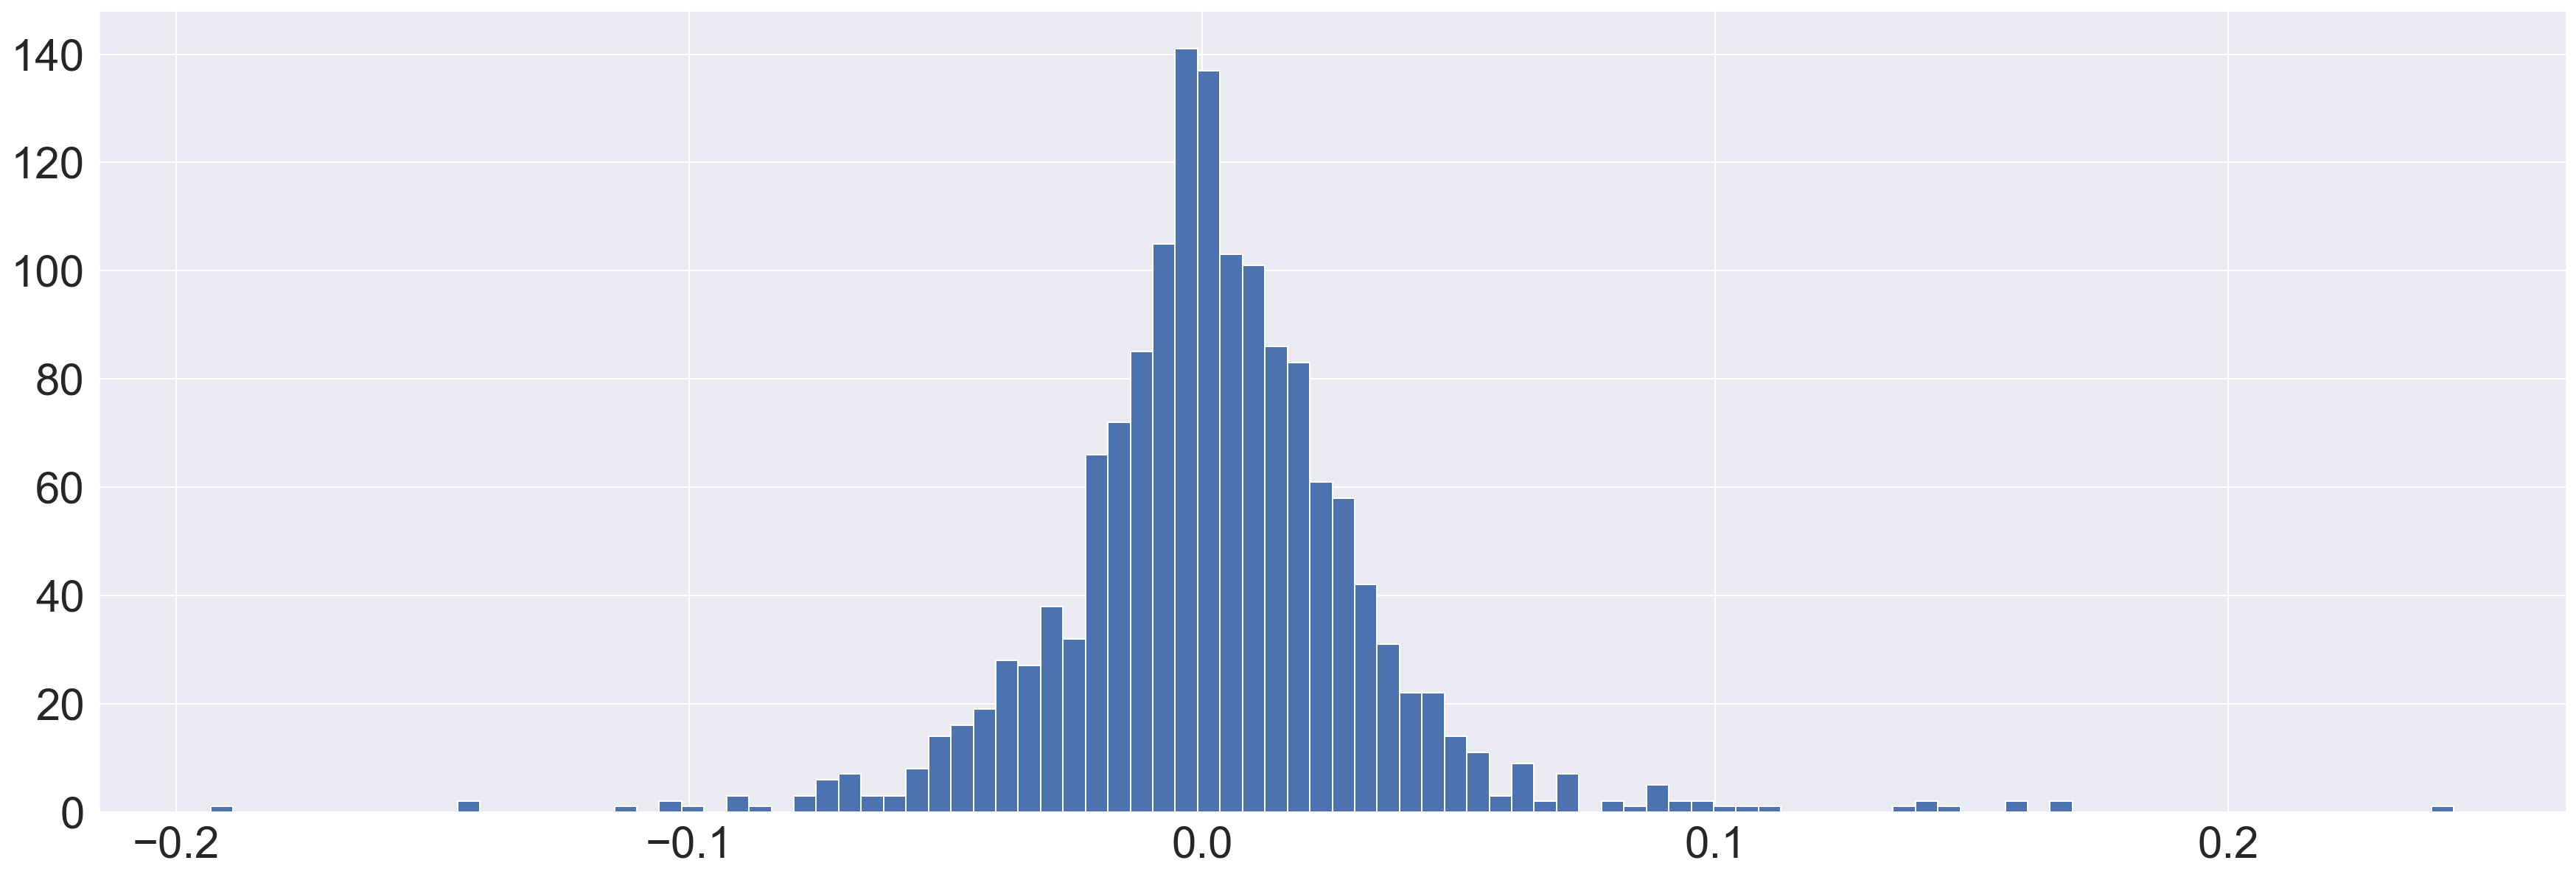

In [235]:
plt.figure(figsize=(30, 10))
plt.hist(top_returns['TSLA'].to_numpy(), bins=100);

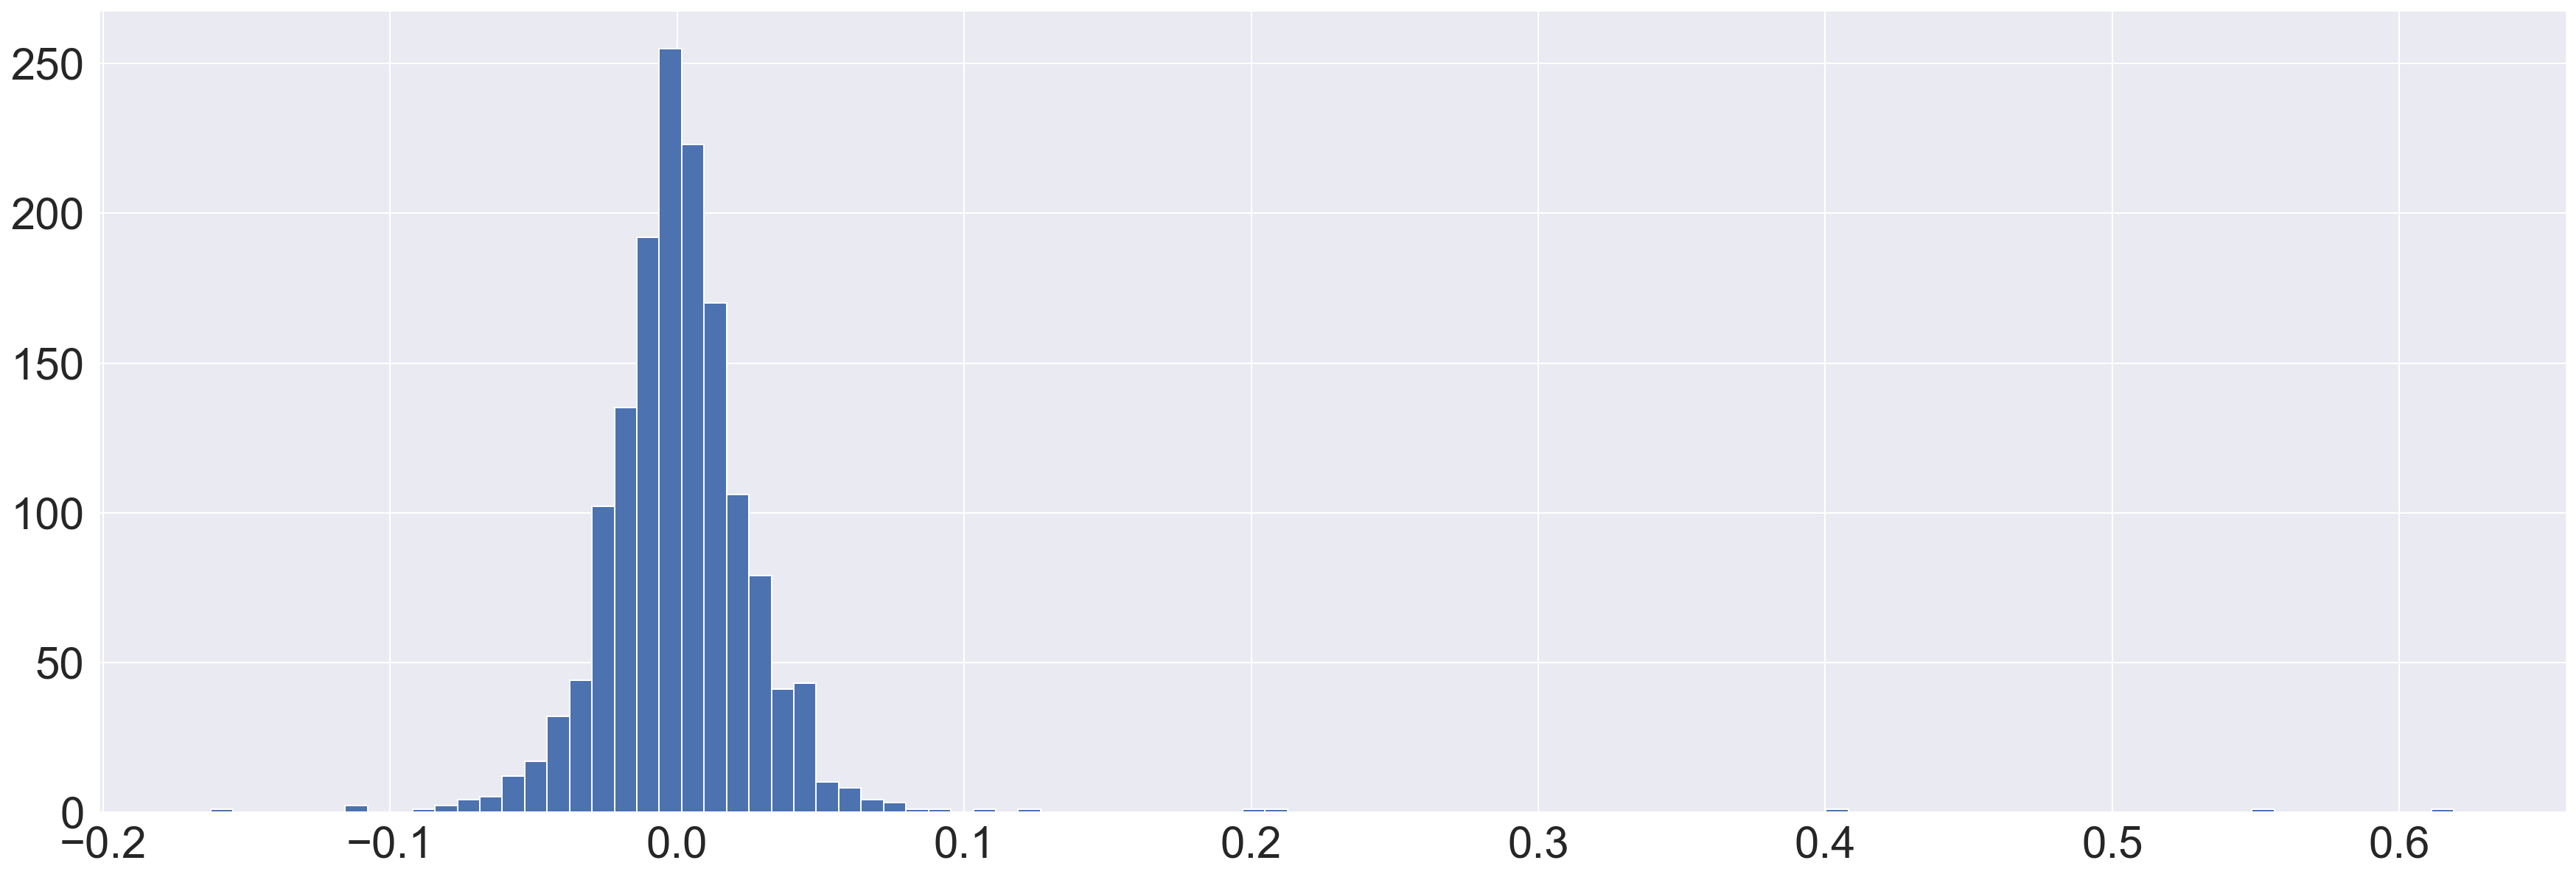

In [236]:
plt.figure(figsize=(30, 10))
plt.hist(top_returns['VRTX'].to_numpy(), bins=100);

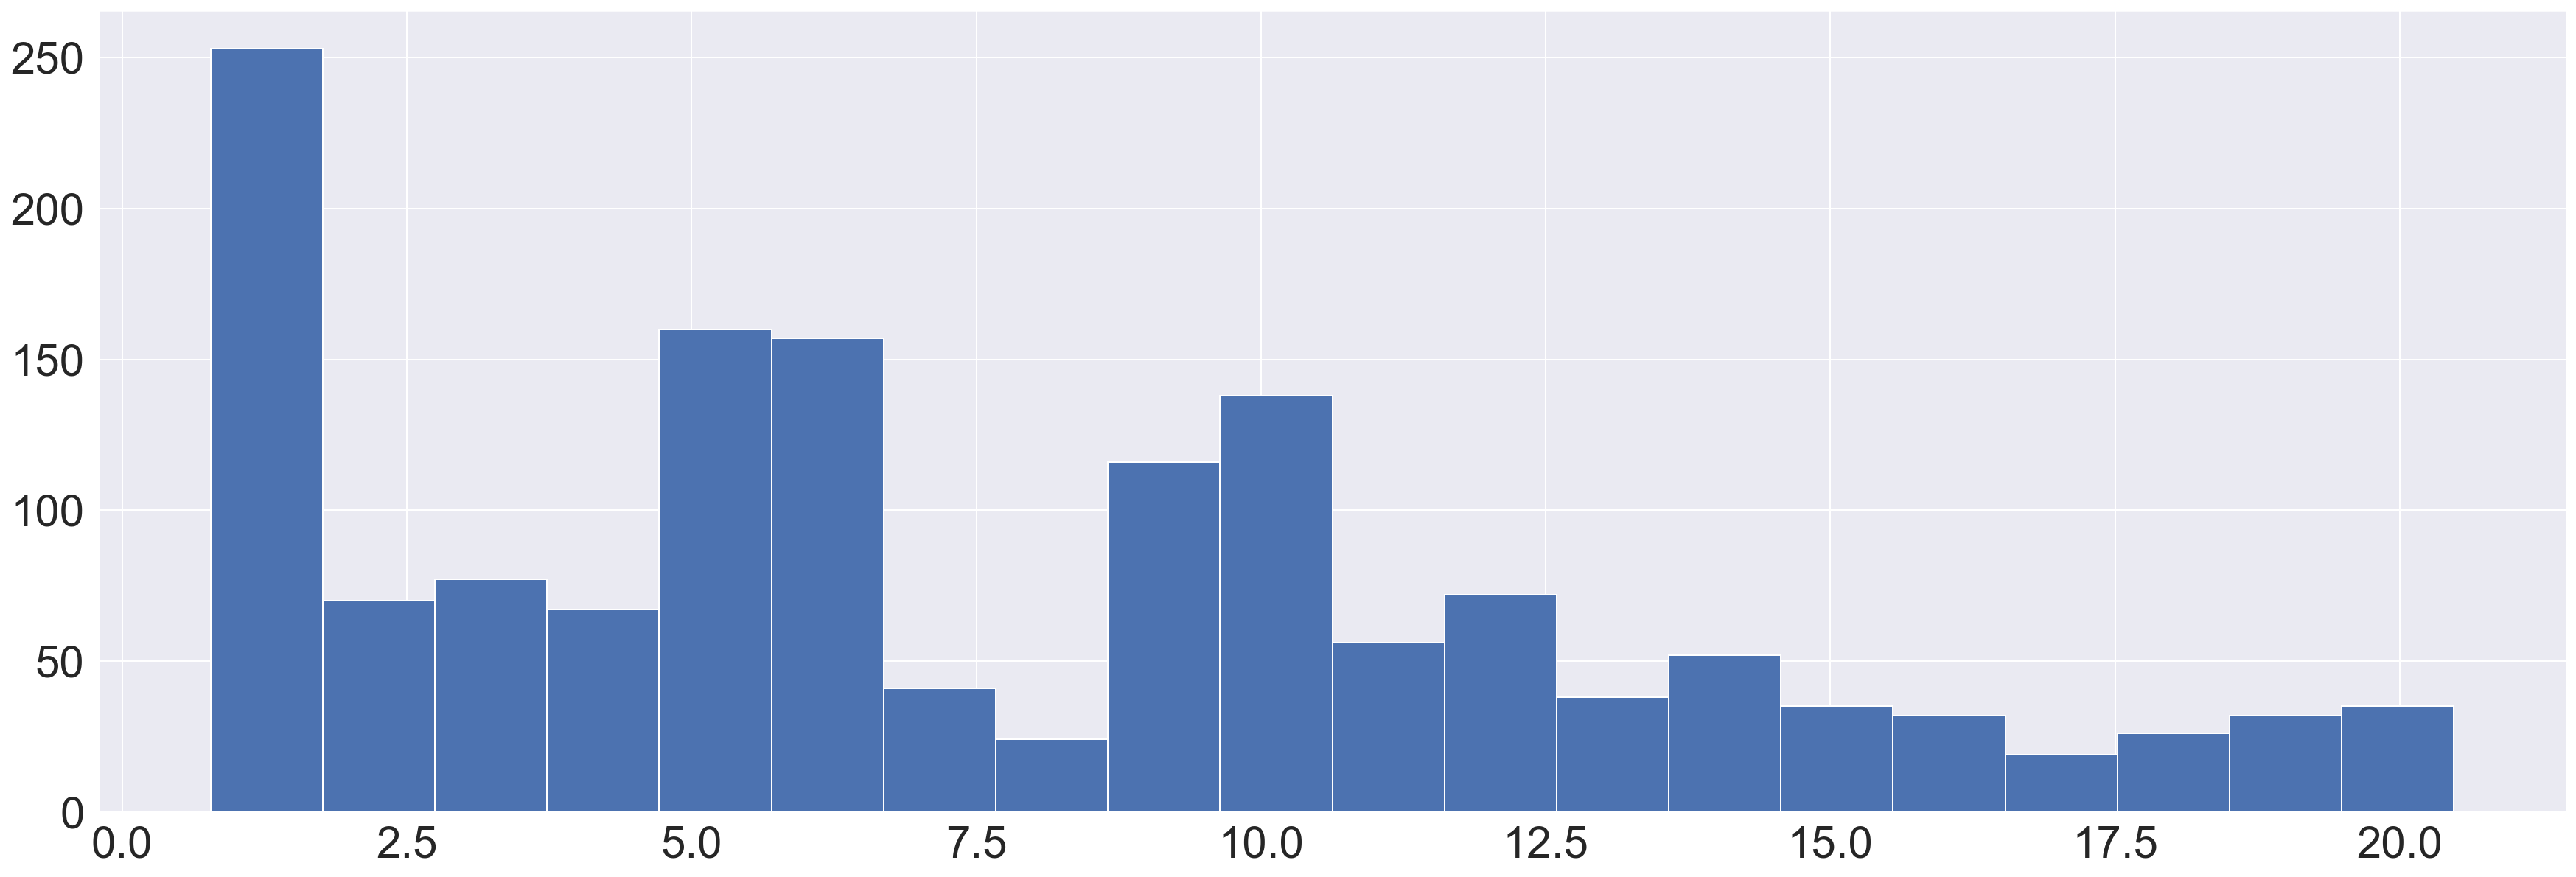

In [237]:
top_returns_add = (top_returns + 1).cumprod(axis=0)

plt.figure(figsize=(30, 10))
plt.hist(top_returns_add['NFLX'].to_numpy(), bins=20);

In [238]:
%run single_ppca.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

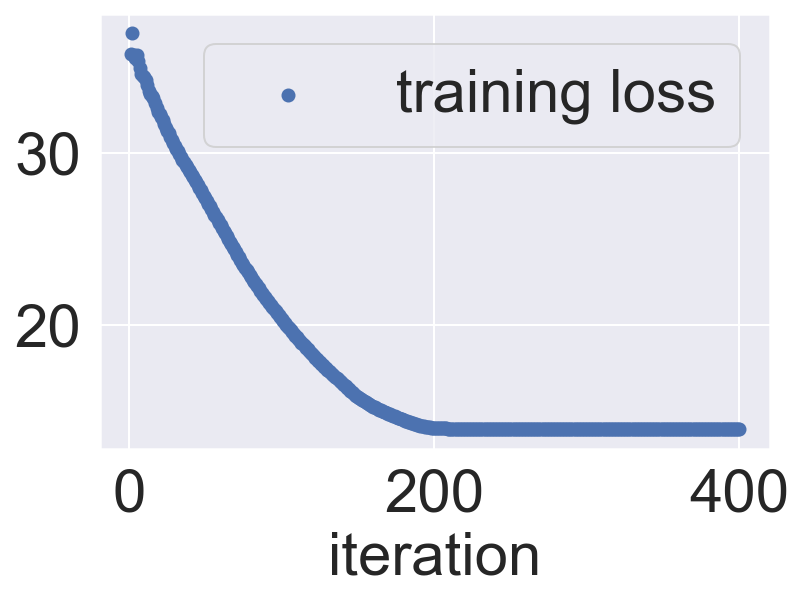

In [239]:
import single_ppca

W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 8)

In [240]:
transformed_top_returns = single_ppca.transform(top_returns.to_numpy(), W, mu, logsigma2, type='optimal')

In [243]:
def get_test_returns(transformed_top_returns):
    Sigma = np.cov(transformed_top_returns.T)

    means = np.mean(top_returns.to_numpy(), axis=0)

    w_ppca_8 = decrease_risk(means, Sigma, R)

    columns = top_returns.columns.to_numpy()
    return count_portfolio_return(columns, w_ppca_8, returns_test) 

In [244]:
portfolio_return_ppca_8 = get_test_returns(transformed_top_returns)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:07:54 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:07:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:07:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:07:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:07:54 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:07:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

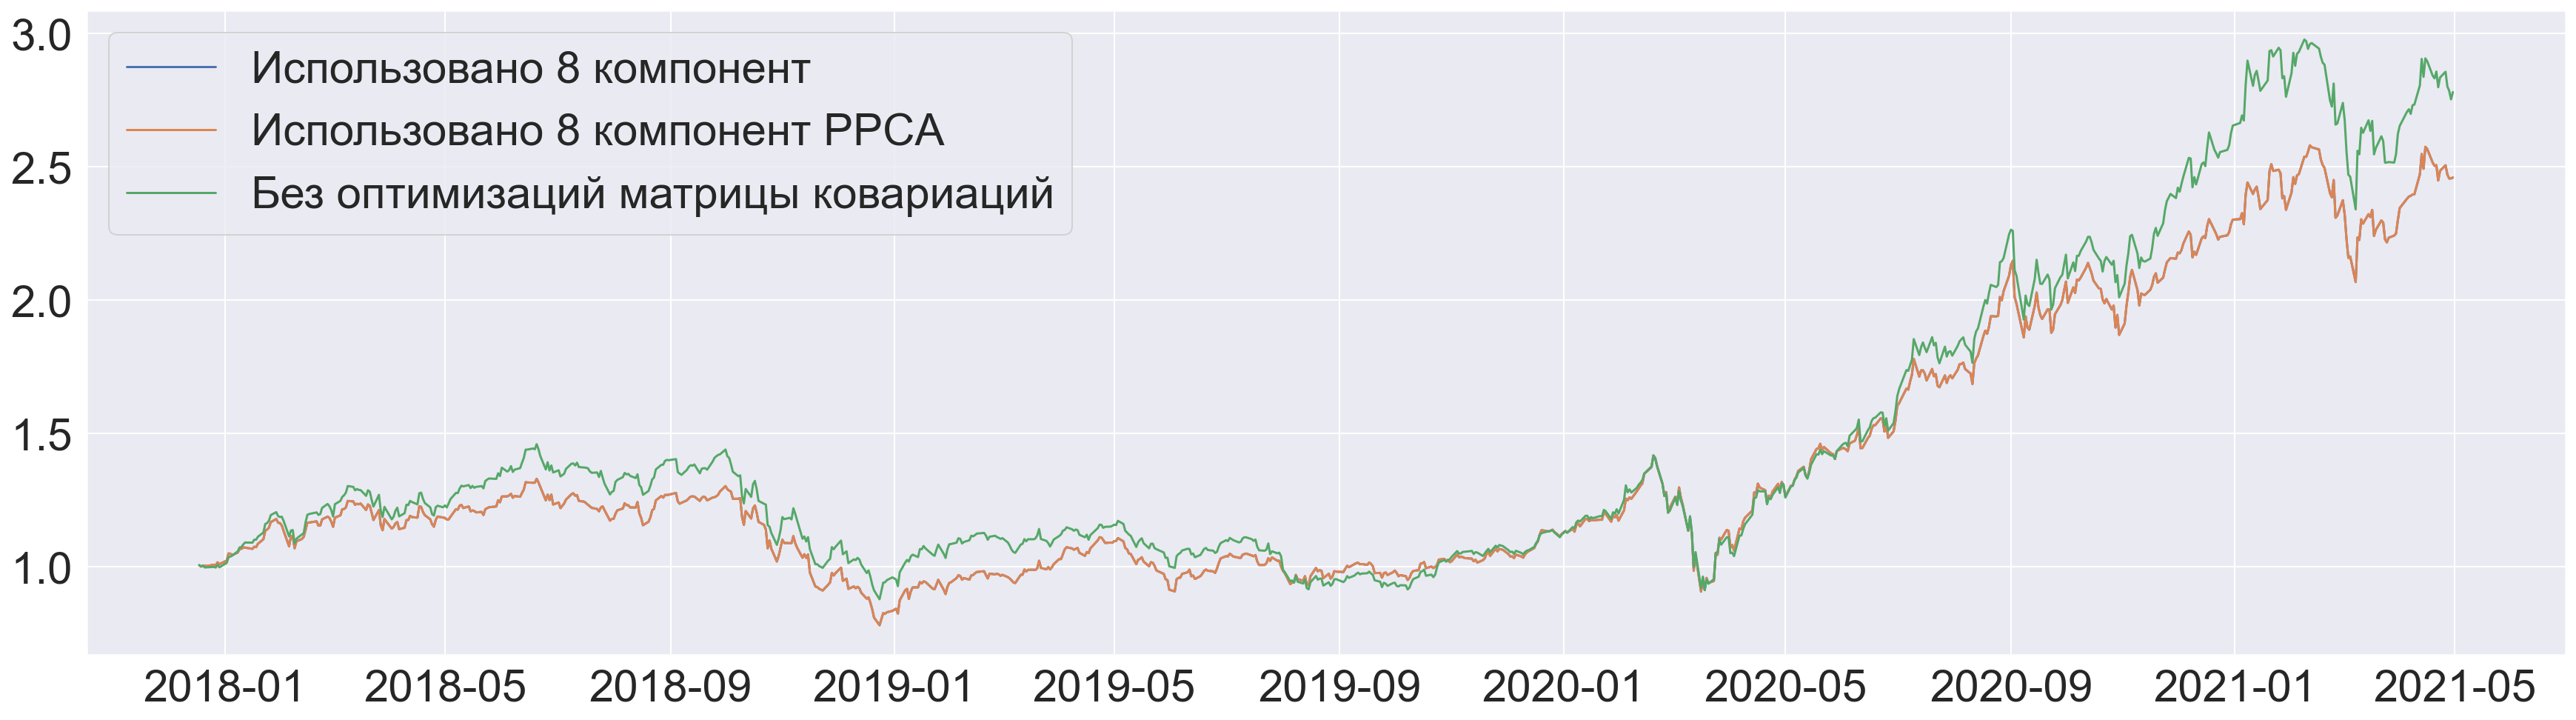

In [245]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_8.index, portfolio_return_8, label='Использовано 8 компонент')
plt.plot(portfolio_return_ppca_8.index, portfolio_return_ppca_8, label='Использовано 8 компонент PPCA')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

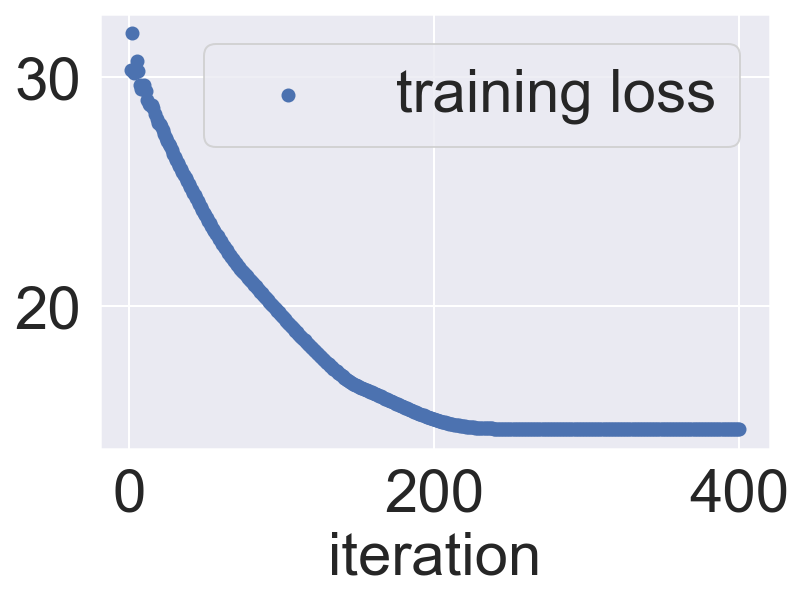

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:08:21 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:08:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:08:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:08:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:08:21 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:08:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [246]:
W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 5)
transformed_top_returns = single_ppca.transform(top_returns.to_numpy(), W, mu, logsigma2, type='optimal')
portfolio_return_ppca_5 = get_test_returns(transformed_top_returns)

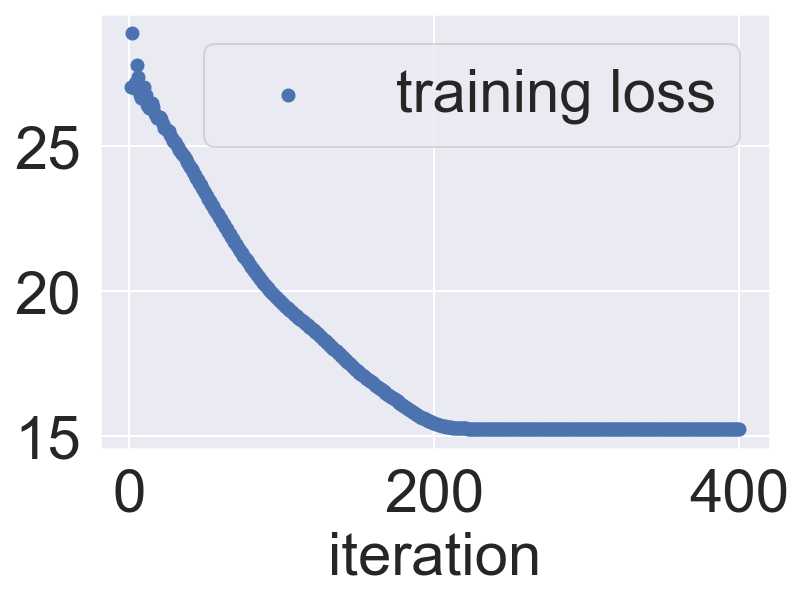

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:08:26 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:08:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:08:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:08:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:08:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:08:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [247]:
W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 3)
transformed_top_returns = single_ppca.transform(top_returns.to_numpy(), W, mu, logsigma2, type='optimal')
portfolio_return_ppca_3 = get_test_returns(transformed_top_returns)

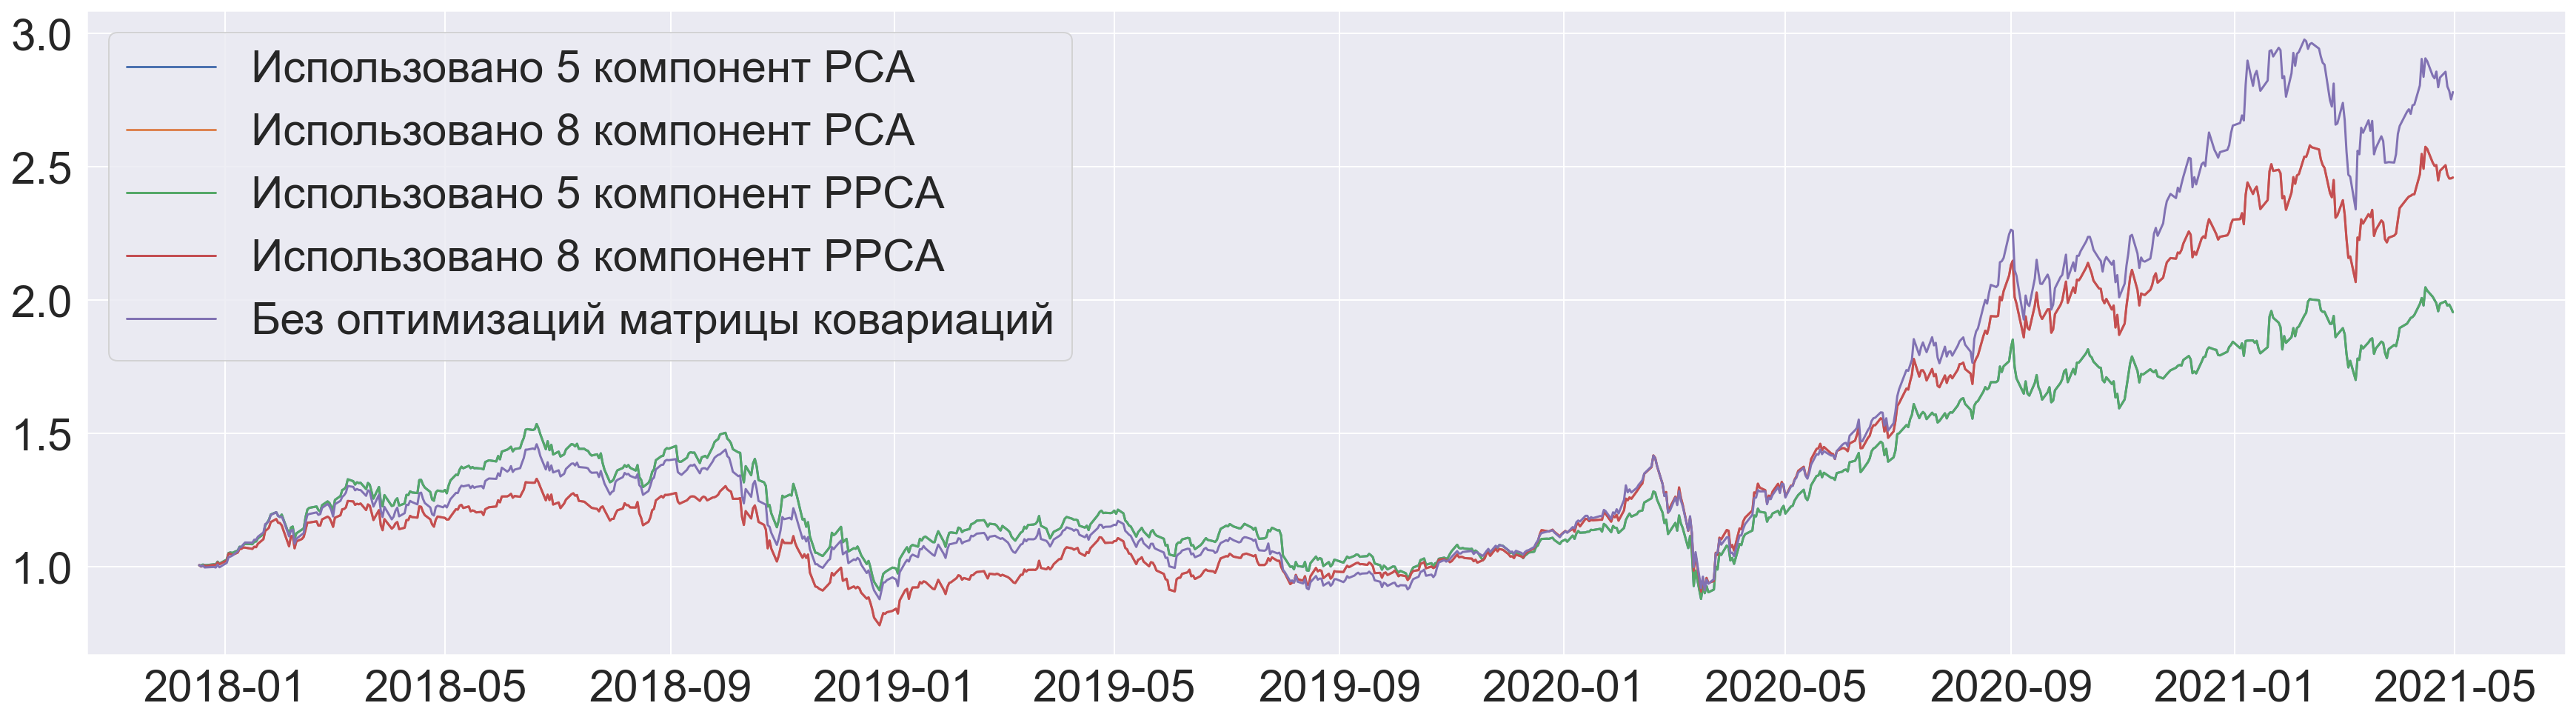

In [252]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_5.index, portfolio_return_5, label='Использовано 5 компонент PCA')
plt.plot(portfolio_return_8.index, portfolio_return_8, label='Использовано 8 компонент PCA')
plt.plot(portfolio_return_ppca_5.index, portfolio_return_ppca_5, label='Использовано 5 компонент PPCA')
plt.plot(portfolio_return_ppca_8.index, portfolio_return_ppca_8, label='Использовано 8 компонент PPCA')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

Попробуем получить данные при помощи генеративной модели.

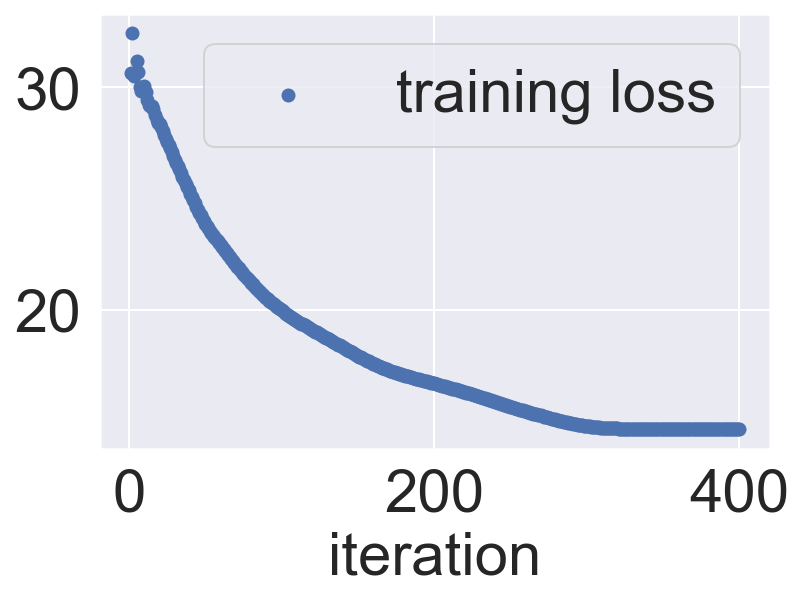

In [253]:
W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 5)

In [254]:
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_5_1 = get_test_returns(generated_returns)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:10:40 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:10:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:10:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:10:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:10:40 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:10:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [255]:
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_5_2 = get_test_returns(generated_returns)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:10:41 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:10:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:10:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:10:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:10:41 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:10:41 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [256]:
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_5_3 = get_test_returns(generated_returns)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:10:43 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:10:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:10:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:10:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:10:43 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:10:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

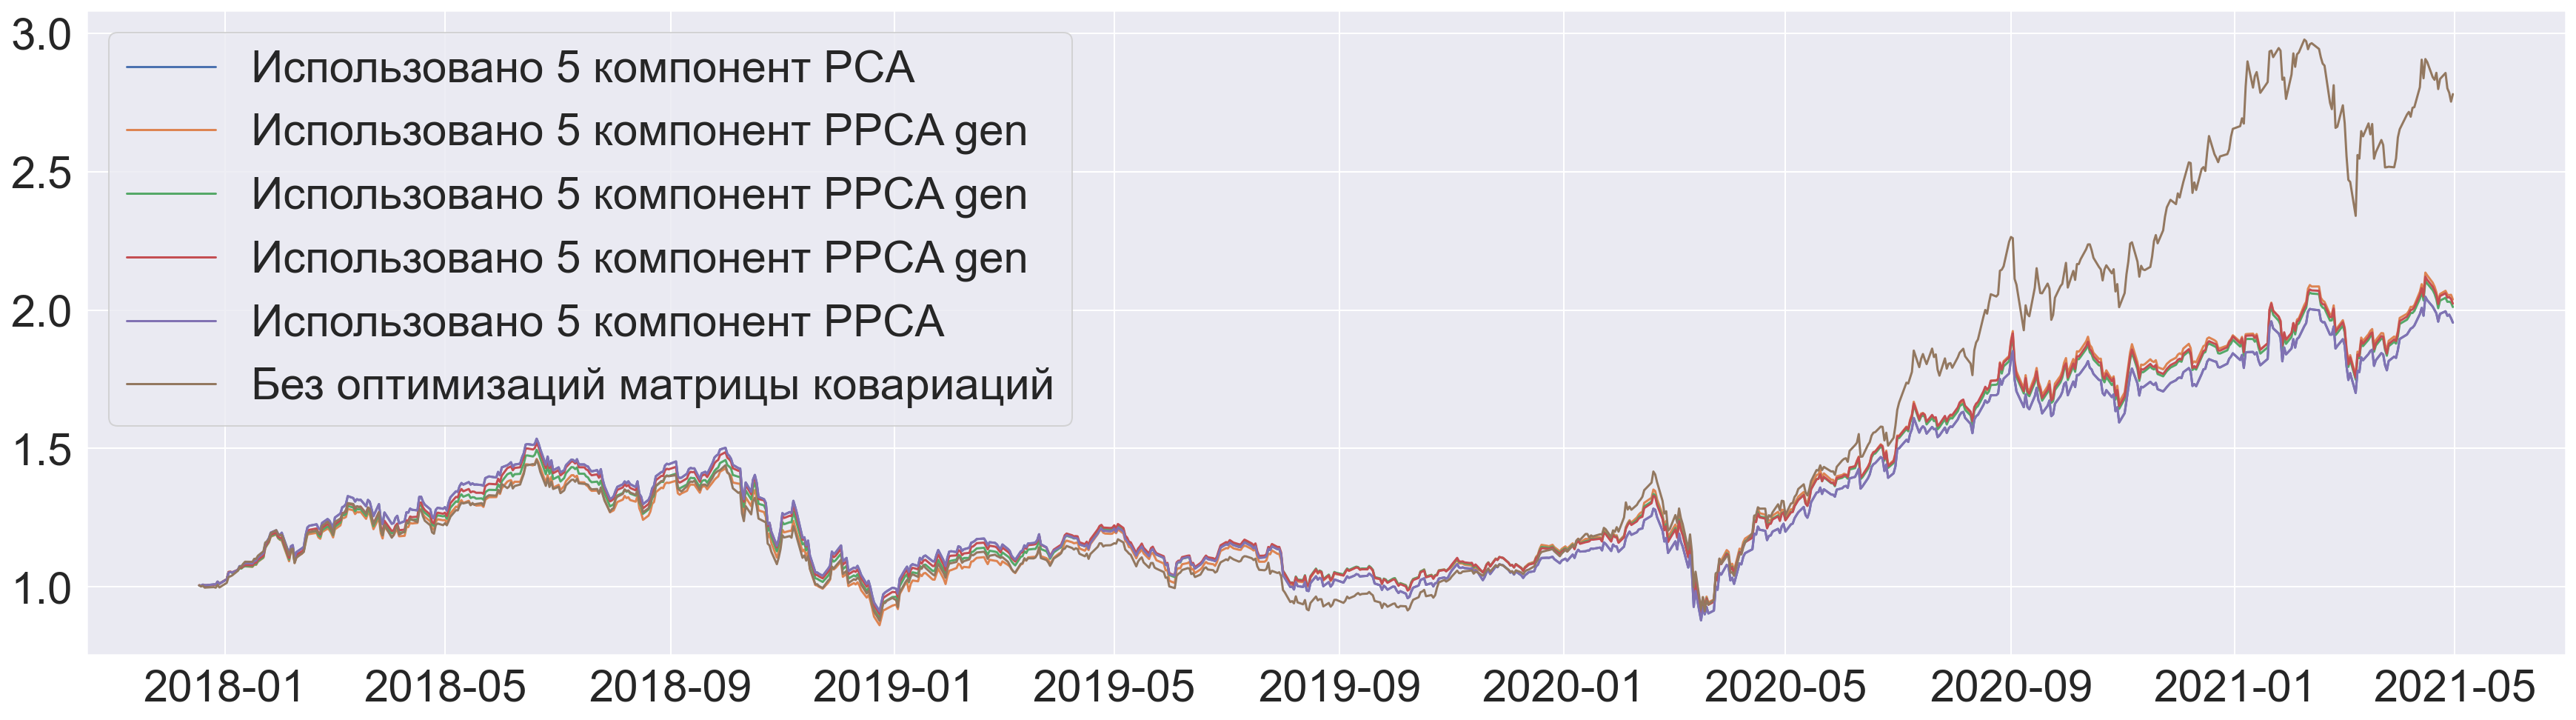

In [263]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_5.index, portfolio_return_5, label='Использовано 5 компонент PCA')
plt.plot(portfolio_return_ppca_gen_5_1.index, portfolio_return_ppca_gen_5_1, label='Использовано 5 компонент PPCA gen')
plt.plot(portfolio_return_ppca_gen_5_2.index, portfolio_return_ppca_gen_5_2, label='Использовано 5 компонент PPCA gen')
plt.plot(portfolio_return_ppca_gen_5_3.index, portfolio_return_ppca_gen_5_3, label='Использовано 5 компонент PPCA gen')
plt.plot(portfolio_return_ppca_5.index, portfolio_return_ppca_5, label='Использовано 5 компонент PPCA')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

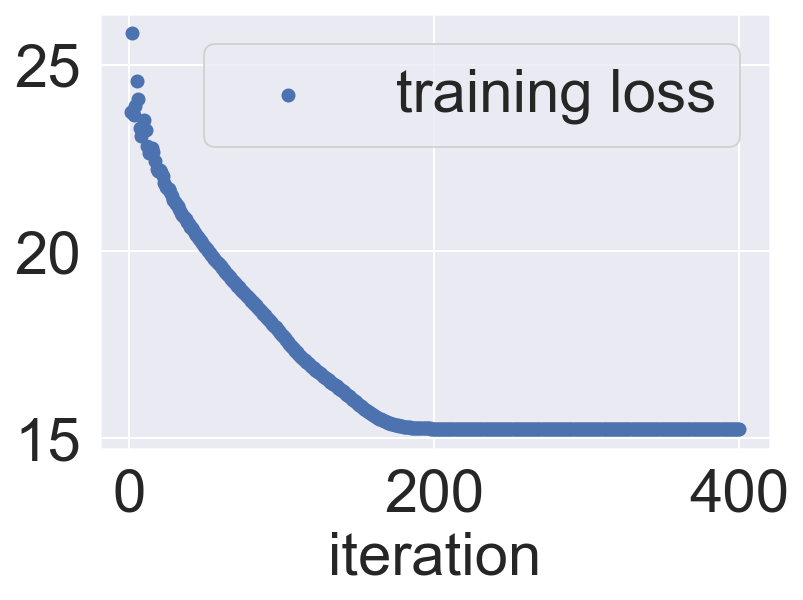

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:12:54 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:12:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:12:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:12:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:12:54 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:12:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

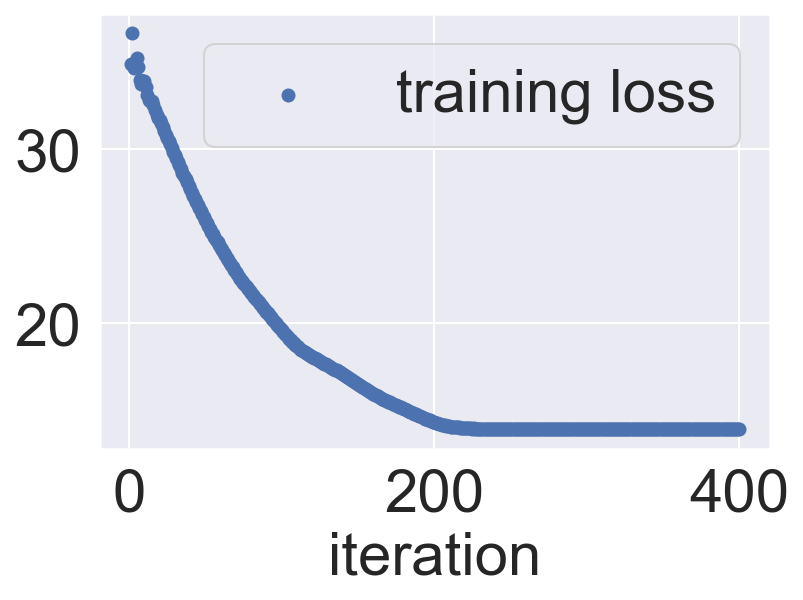

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:13:00 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:13:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:13:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:13:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:13:00 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:13:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

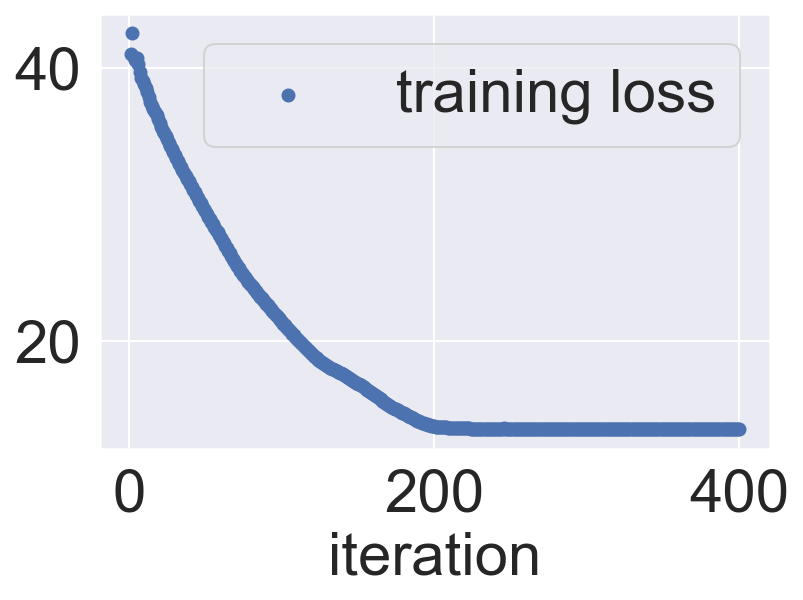

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 10:13:06 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 15 10:13:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 10:13:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 10:13:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 10:13:06 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 10:13:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [264]:
W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 3)
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_3 = get_test_returns(generated_returns)

W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 8)
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_8 = get_test_returns(generated_returns)

W, mu, logsigma2 = single_ppca.find_params(top_returns.to_numpy(), 12)
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_ppca_gen_12 = get_test_returns(generated_returns)

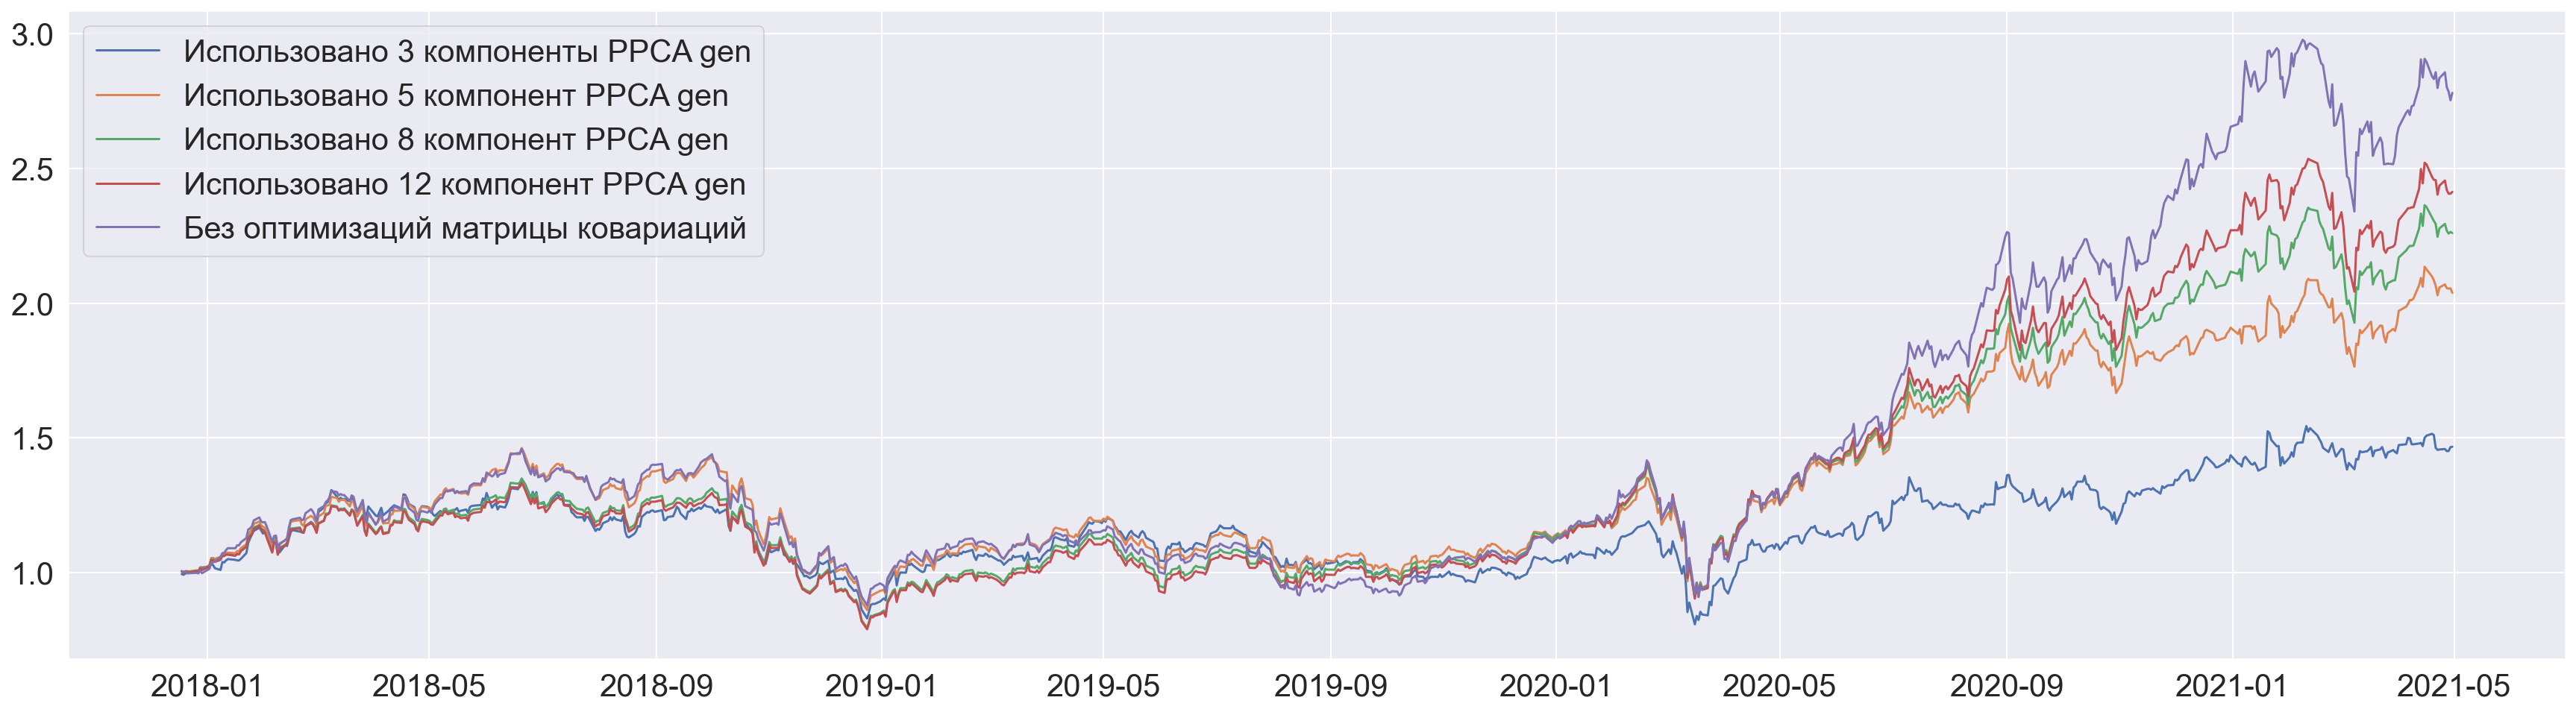

In [320]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_ppca_gen_5_2.index, portfolio_return_ppca_gen_3, label='Использовано 3 компоненты PPCA gen')
plt.plot(portfolio_return_ppca_gen_5_1.index, portfolio_return_ppca_gen_5_1, label='Использовано 5 компонент PPCA gen')
plt.plot(portfolio_return_ppca_gen_5_2.index, portfolio_return_ppca_gen_8, label='Использовано 8 компонент PPCA gen')
plt.plot(portfolio_return_ppca_gen_5_3.index, portfolio_return_ppca_gen_12, label='Использовано 12 компонент PPCA gen')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

Попробуем улучшить распределение данных.

In [266]:
import statsmodels.api as sm

sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina" 

def draw_qqplot(x, dist):
    fig, ax = plt.subplots(figsize=(10, 10))
    loc, scale = dist.fit(x)
    sm.qqplot(x, ax=ax, line='45', dist=dist, loc=loc, scale=scale)
    plt.show()

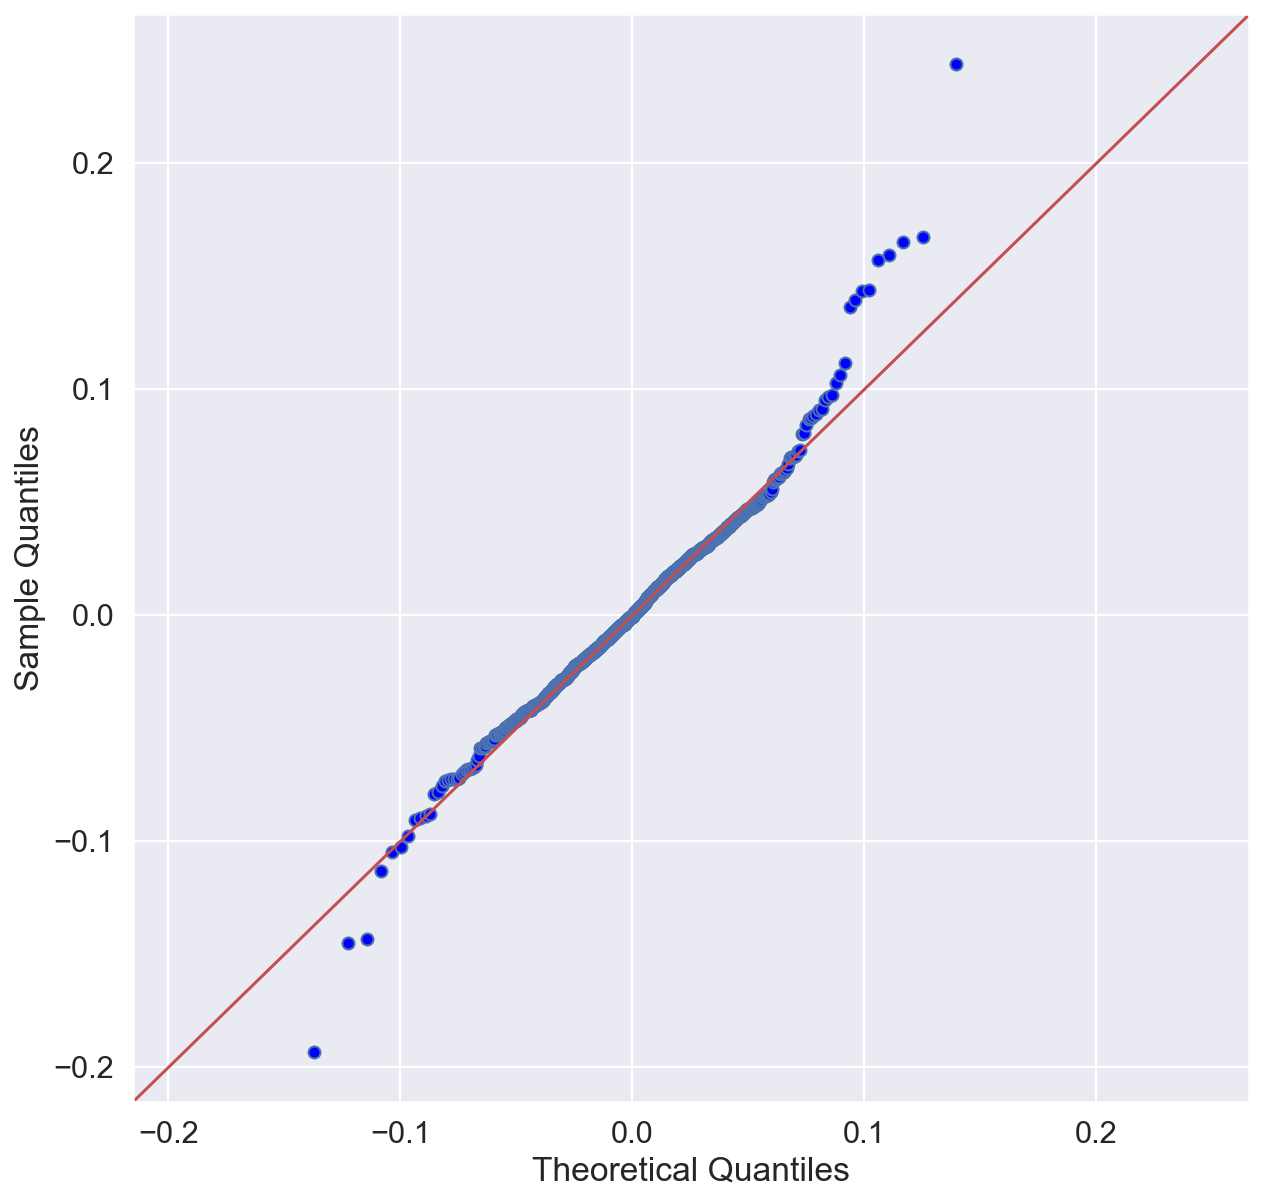

In [267]:
draw_qqplot(top_returns['TSLA'], sps.laplace)

У нашего распределения края ниже, чем у подобранного лапласовского.

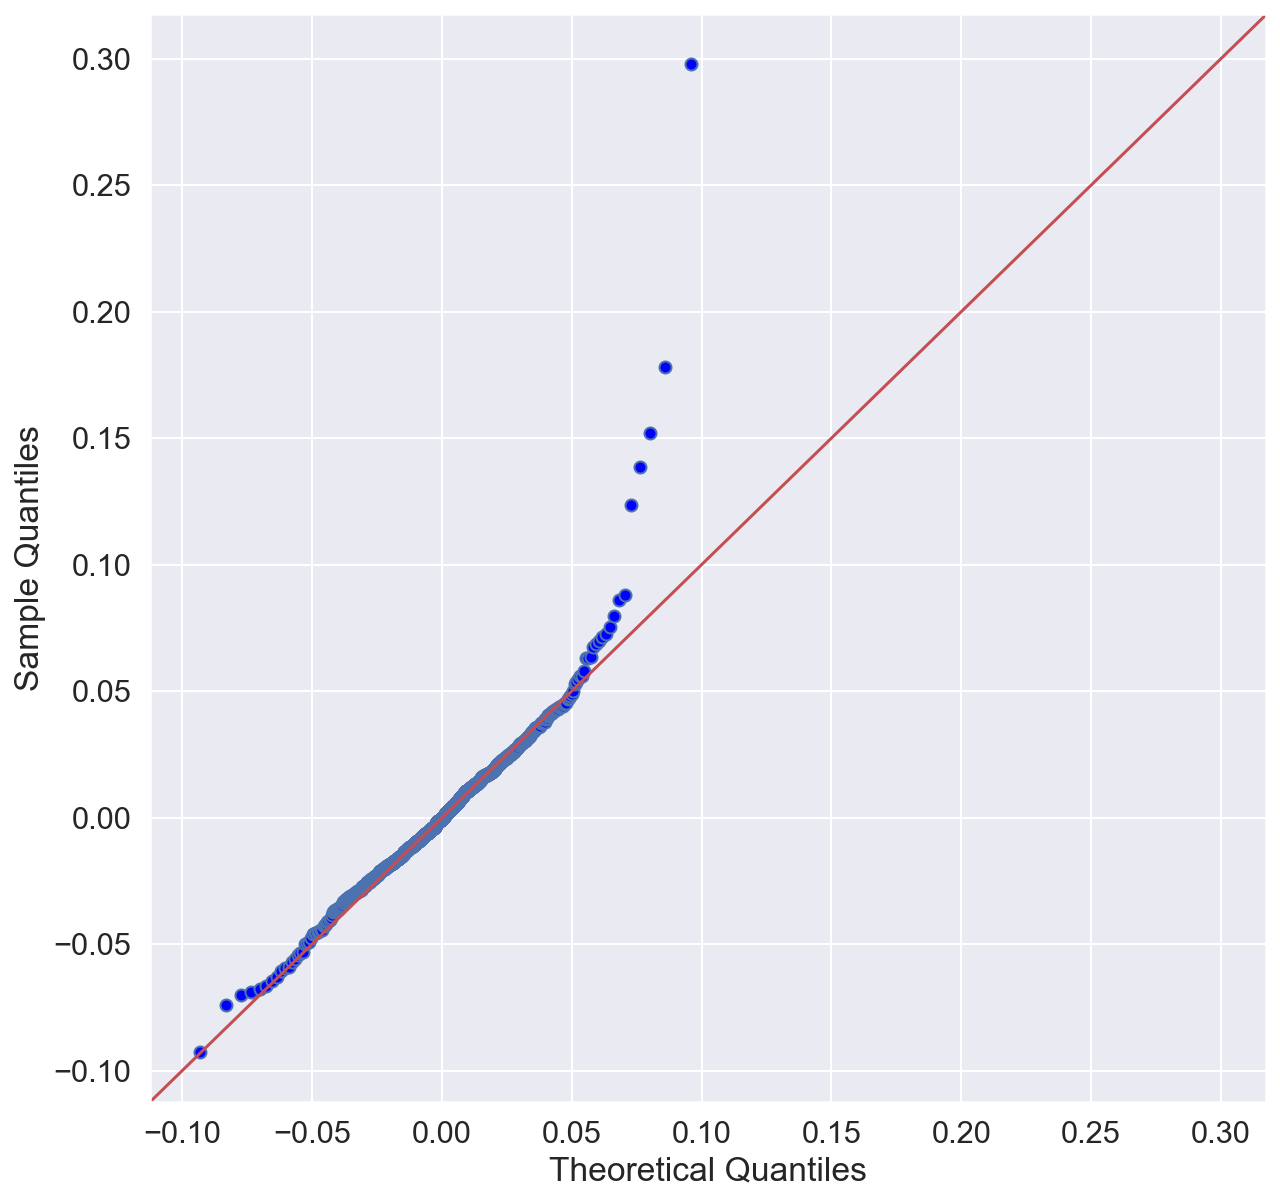

In [268]:
draw_qqplot(top_returns['NVDA'], sps.laplace)

In [349]:
top_returns_norm = top_returns.copy()
for col in top_returns.columns:
    loc, scale = sps.laplace.fit(top_returns[col])
    top_returns_norm[col] = np.clip(sps.laplace(loc, scale).cdf(top_returns[col]), 0.000001, 0.999999)
    top_returns_norm[col] = sps.norm().ppf(top_returns_norm[col])

In [302]:
sps.norm().ppf(0.999999)

4.753424308817087

In [306]:
top_returns_norm.isna().all()
top_returns_norm[top_returns_norm['CSC'] == np.inf]
# top_returns_norm[top_returns_norm['CSC'] > 0.99]

Empty DataFrame
Columns: [NFLX, TSLA, NKTR, NVDA, ABMD, STZ, ALGN, AVGO, INCY, ILMN, MU, NXPI, TTWO, DXCM, REGN, MPWR, DAL, LUV, CSC, VRTX]
Index: []

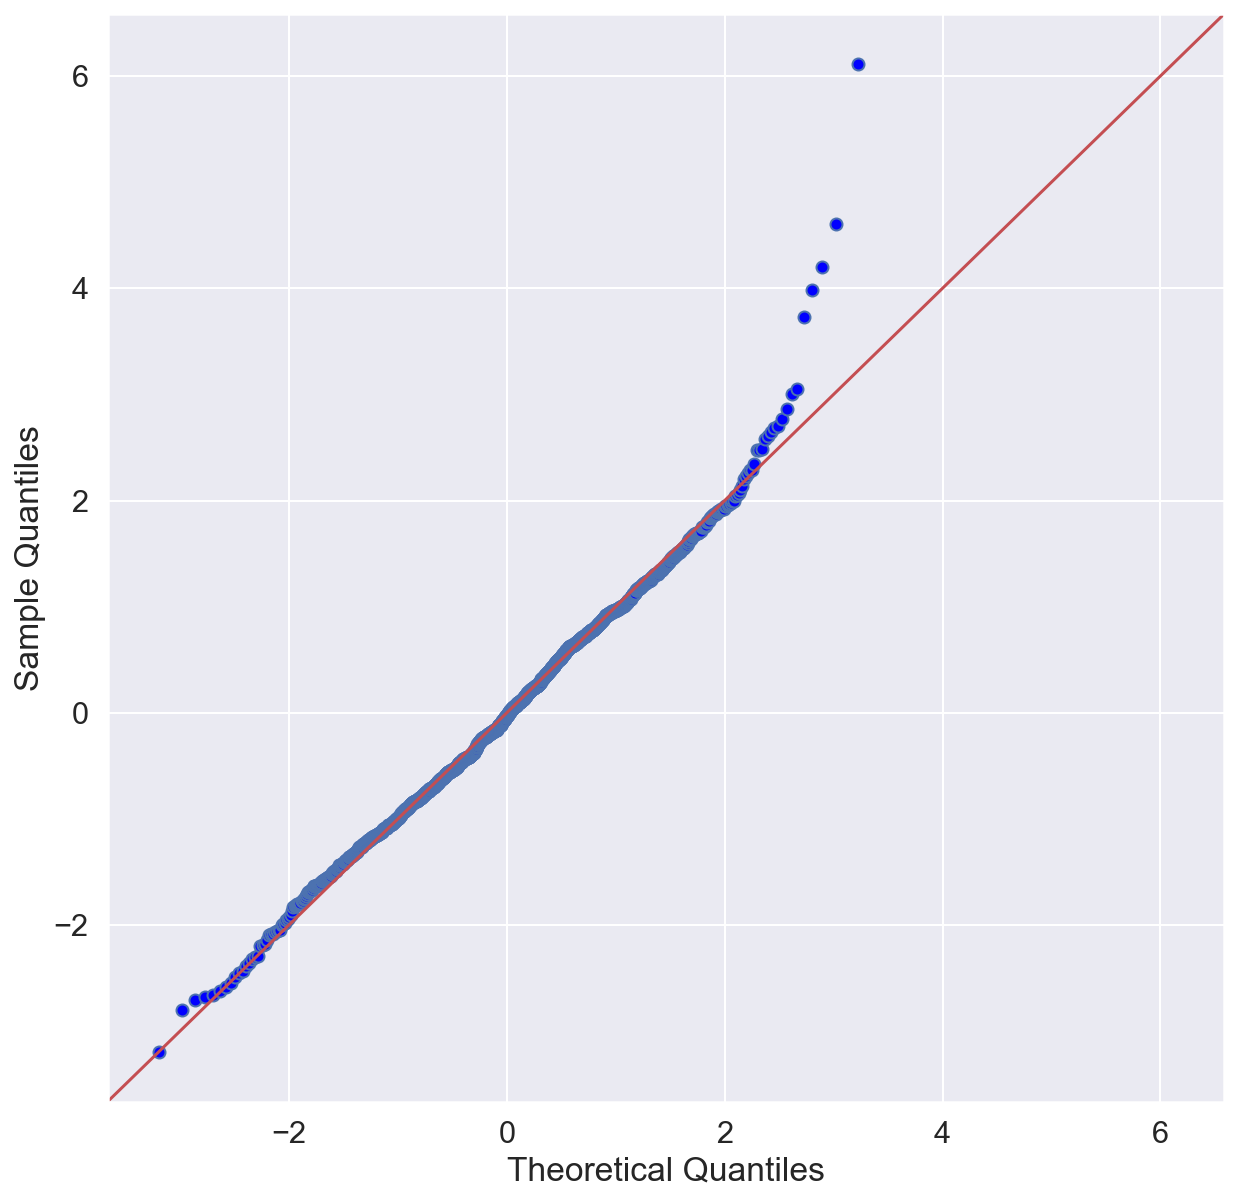

In [153]:
draw_qqplot(top_returns_norm['NVDA'], sps.norm)

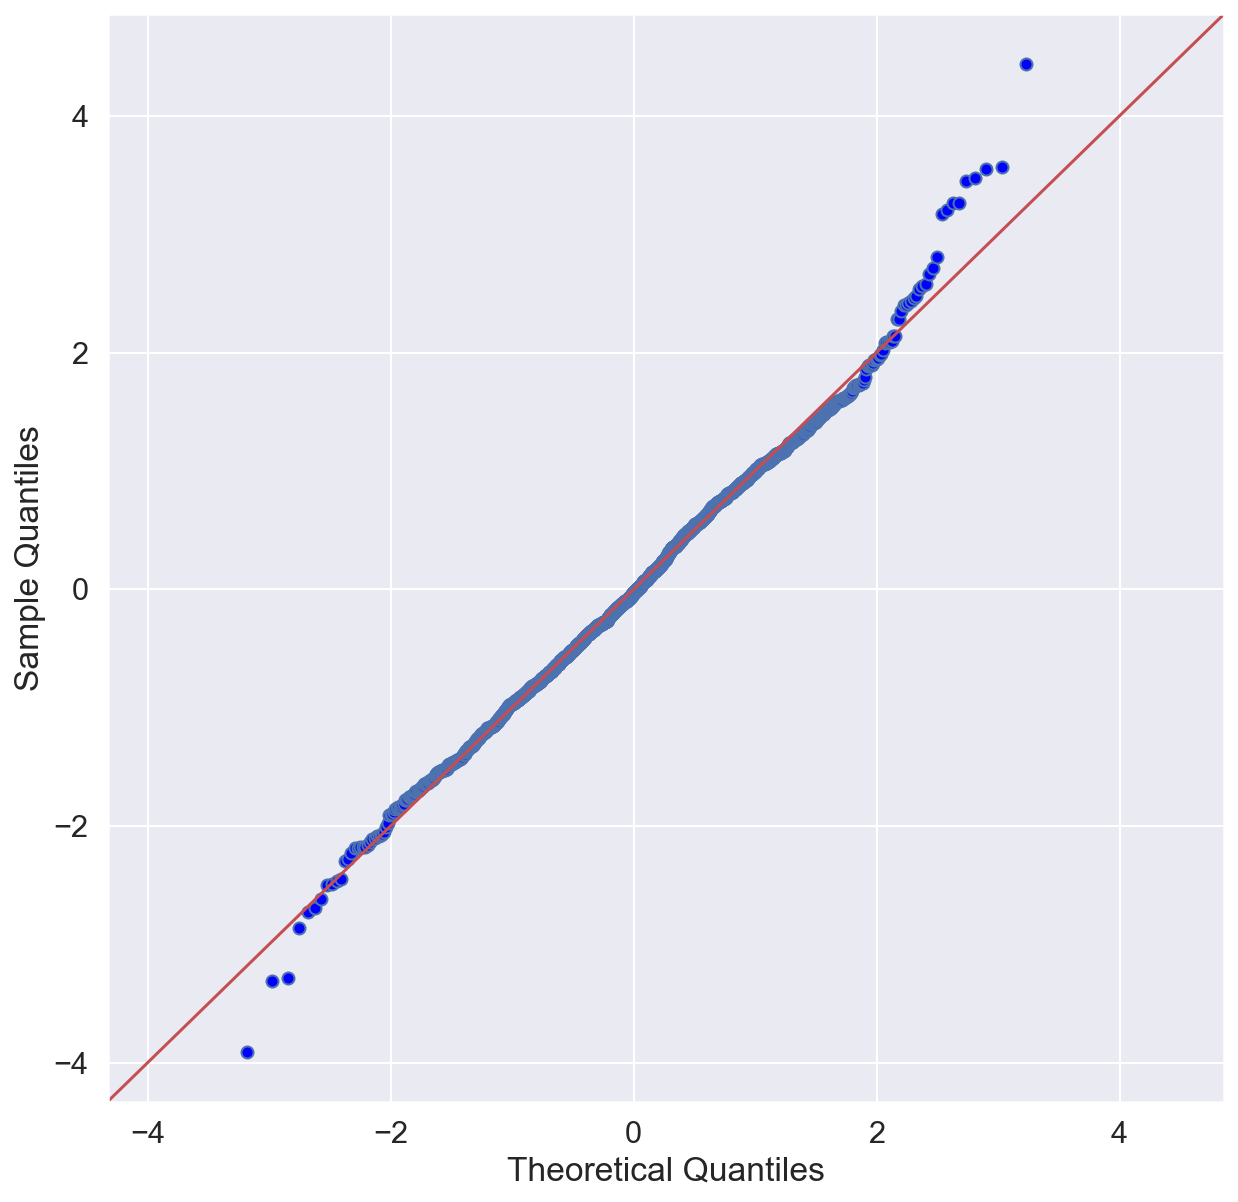

In [154]:
draw_qqplot(top_returns_norm['TSLA'], sps.norm)

In [308]:
print(top_returns_norm['CSC'].isna().any(),
    np.isnan(np.cov(top_returns_norm.T)).any())

False False


In [309]:
top_returns_norm.shape

(1500, 20)

In [350]:
Sigma = np.cov(top_returns_norm.to_numpy().T)

means = np.mean(top_returns.to_numpy(), axis=0)

w_ppca = decrease_risk(means, Sigma, R)

columns = top_returns.columns.to_numpy()
portfolio_return_to_norm = count_portfolio_return(columns, w_ppca, returns_test) 

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 04:16:21 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 04:16:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 04:16:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 04:16:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 04:16:21 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 16 04:16:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

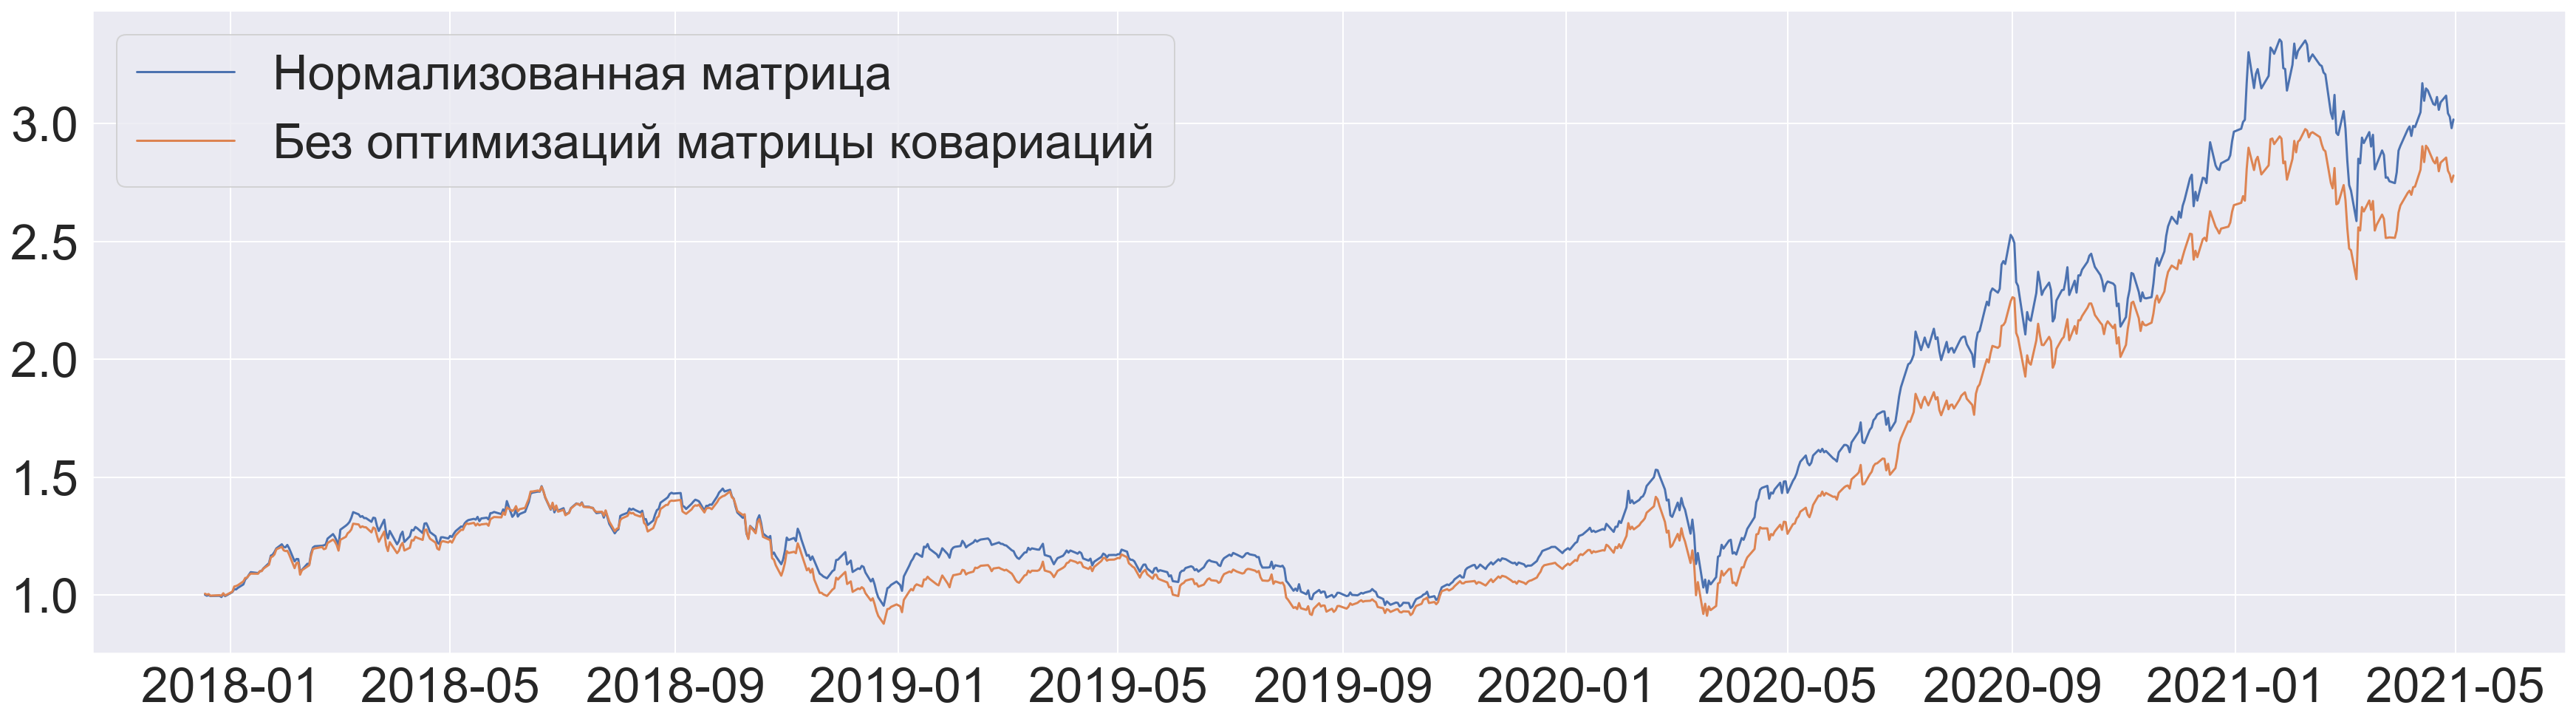

In [351]:
sns.set(style='darkgrid', font_scale=3)

plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_to_norm.index, portfolio_return_to_norm, label='Нормализованная матрица')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.legend();

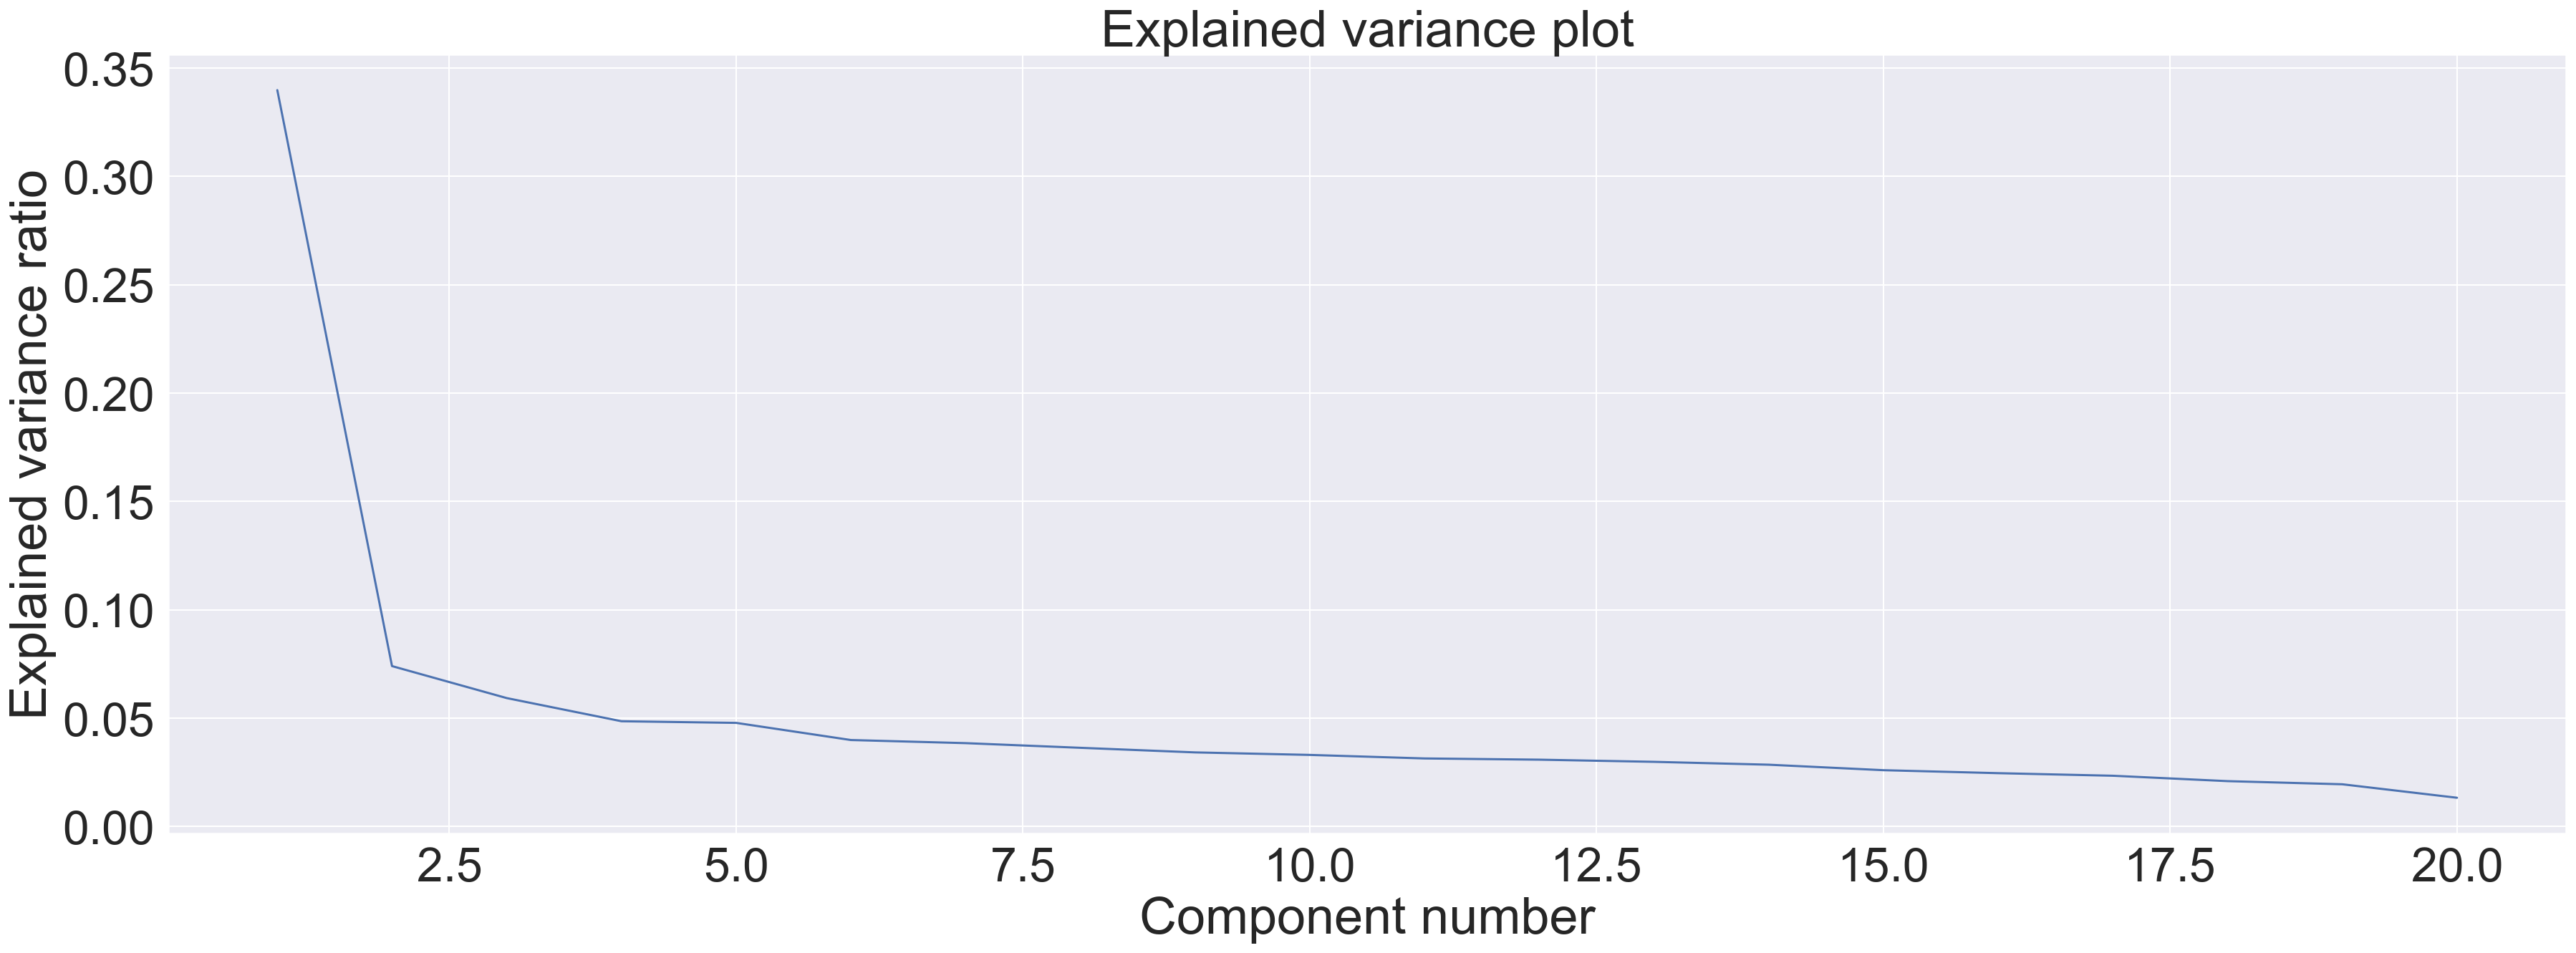

In [327]:
pca = PCA(n_components=20)
pca.fit(top_returns_norm)

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title("Explained variance plot")
ax.set_xlabel("Component number")
ax.set_ylabel("Explained variance ratio")
plt.plot(np.arange(pca.n_components) + 1, pca.explained_variance_ratio_);

In [386]:
def get_pca_test_returns(df, kept_components):
    pca = PCA(n_components=df.shape[1])
    pca.fit(df)
    transformed_top_returns = pca.transform(df)

    transformed_top_returns[:,kept_components:] = 0

    simplified_returns = pca.inverse_transform(transformed_top_returns)

    mu = np.mean(top_returns.to_numpy(), axis=0)

    R = 2e-3
    Sigma = np.cov(simplified_returns.T)

    w = decrease_risk(mu, Sigma, R)

    columns = df.columns.to_numpy()
    return count_portfolio_return(columns, w, returns_test)

In [387]:
portfolio_return_to_norm_pca_4 = get_pca_test_returns(top_returns_norm, 4)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 06:51:10 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 06:51:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 06:51:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 06:51:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 06:51:10 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 16 06:51:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [388]:
portfolio_return_to_norm_pca_12 = get_pca_test_returns(top_returns_norm, 12)
portfolio_return_to_norm_pca_8 = get_pca_test_returns(top_returns_norm, 8)
portfolio_return_to_norm_pca_3 = get_pca_test_returns(top_returns_norm, 3)
portfolio_return_to_norm_pca_2 = get_pca_test_returns(top_returns_norm, 2)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 06:51:13 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 06:51:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 06:51:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 06:51:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 06:51:13 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 16 06:51:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

(CVXPY) Mar 16 06:51:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Mar 16 06:51:13 PM: Applying reduction Dcp2Cone
(CVXPY) Mar 16 06:51:13 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 16 06:51:13 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Mar 16 06:51:13 PM: Applying reduction SCS
(CVXPY) Mar 16 06:51:13 PM: Finished problem compilation (took 4.033e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 06:51:13 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 21, constraints m:

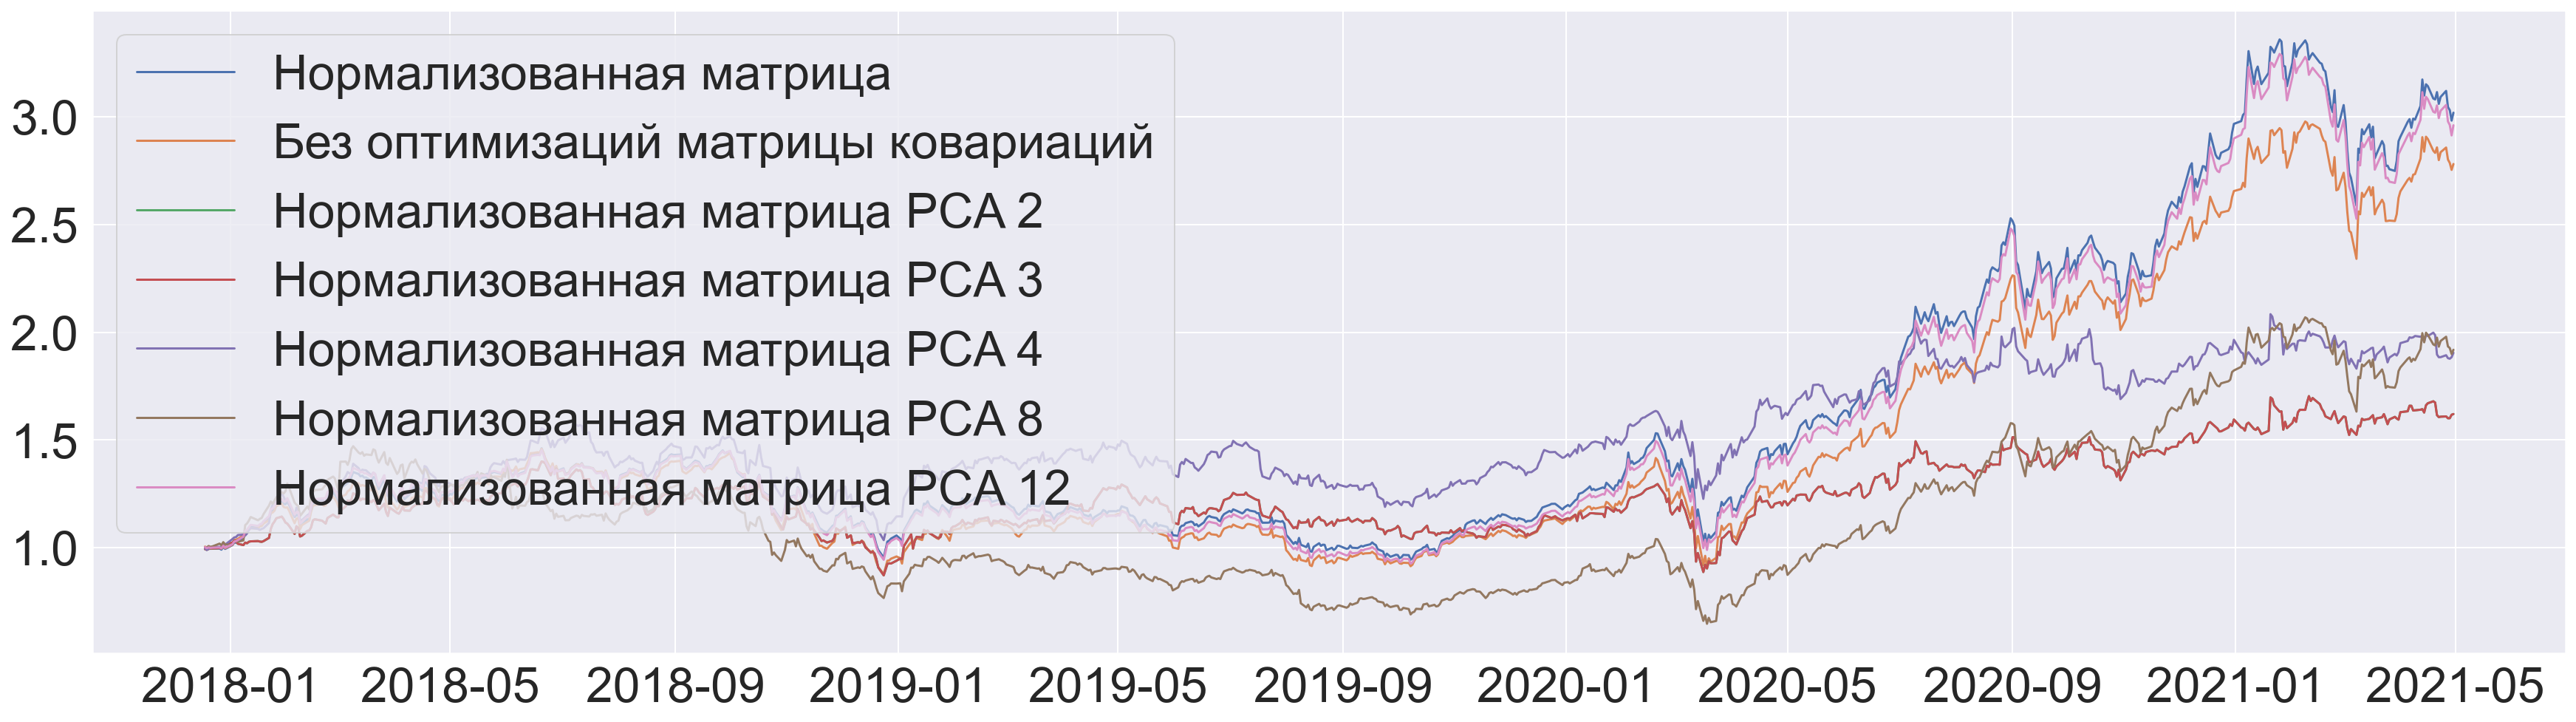

In [389]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_to_norm.index, portfolio_return_to_norm, label='Нормализованная матрица')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_2, label='Нормализованная матрица PCA 2')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_3, label='Нормализованная матрица PCA 3')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_4, label='Нормализованная матрица PCA 4')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_8, label='Нормализованная матрица PCA 8')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_12, label='Нормализованная матрица PCA 12')
plt.legend(loc='upper left');

In [390]:
portfolio_return_to_norm_pca_5 = get_pca_test_returns(top_returns_norm, 5)
portfolio_return_to_norm_pca_6 = get_pca_test_returns(top_returns_norm, 6)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 06:58:17 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 06:58:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 06:58:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 06:58:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 06:58:17 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 16 06:58:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

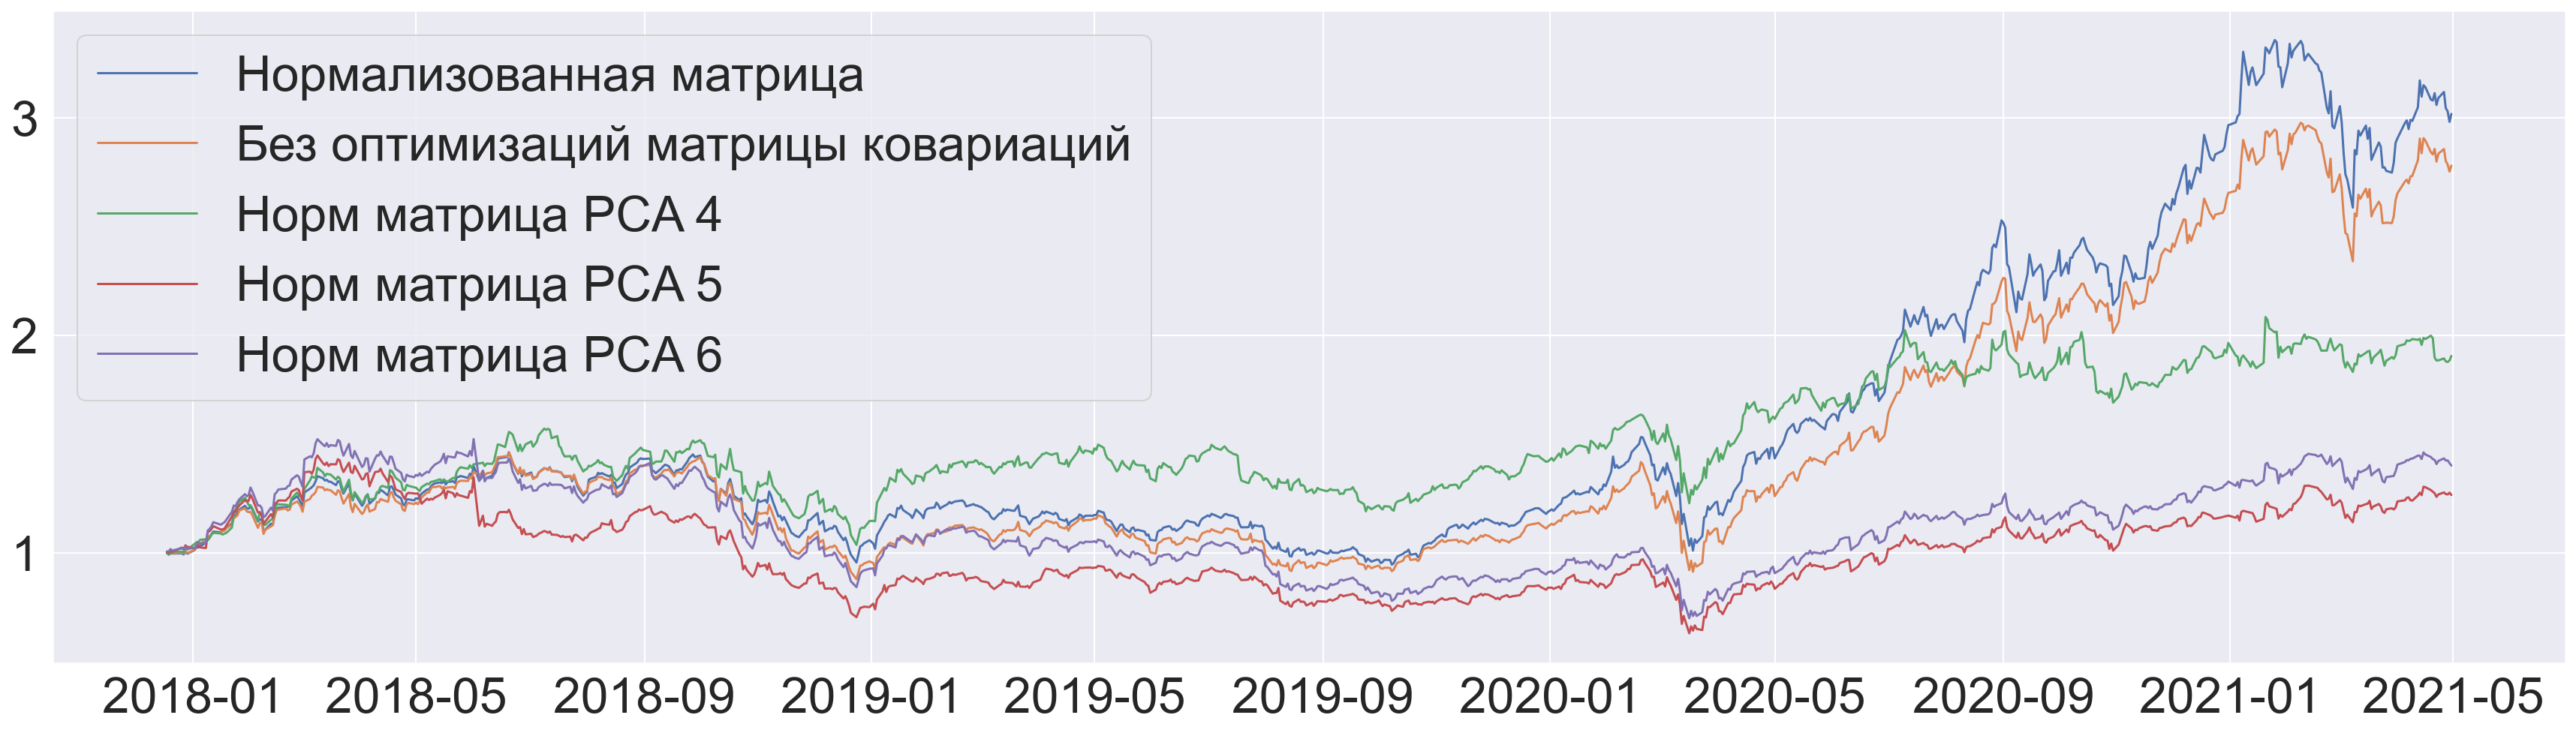

In [392]:
plt.figure(figsize=(30, 8))
plt.plot(portfolio_return_to_norm.index, portfolio_return_to_norm, label='Нормализованная матрица')
plt.plot(portfolio_return_no_opt.index, portfolio_return_no_opt, label='Без оптимизаций матрицы ковариаций')
plt.plot(portfolio_return_to_norm_pca_4.index, portfolio_return_to_norm_pca_4, label='Норм матрица PCA 4')
plt.plot(portfolio_return_to_norm_pca_5.index, portfolio_return_to_norm_pca_5, label='Норм матрица PCA 5')
plt.plot(portfolio_return_to_norm_pca_6.index, portfolio_return_to_norm_pca_6, label='Норм матрица PCA 6')
plt.legend(loc='upper left');

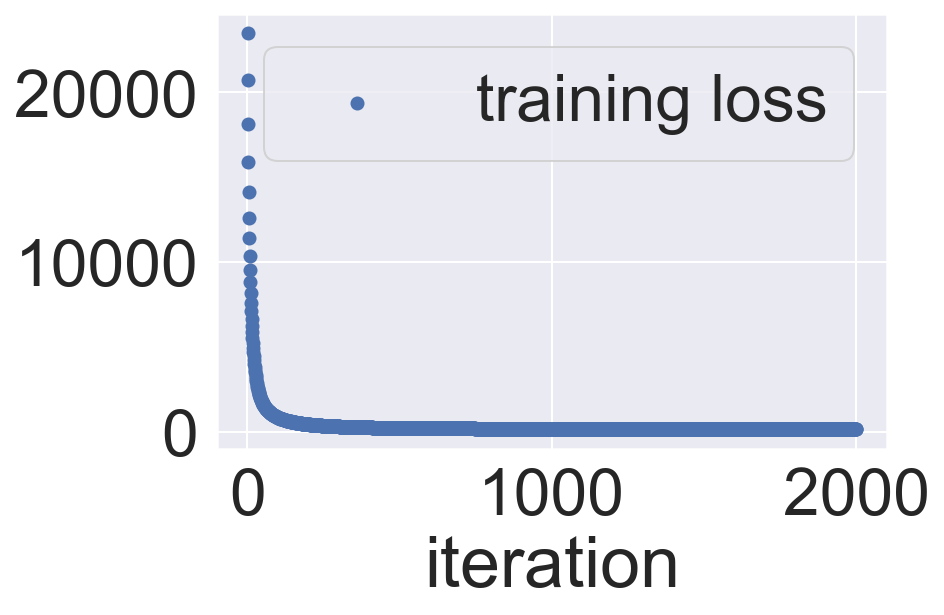

163.88571166992188
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 04:34:05 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 04:34:05 PM: It is compliant with the following grammars: 
(CVXPY) Mar 16 04:34:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 04:34:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var18947, [[ 43.77201788  47.03373056  12.80854691  46.30946399  10.00383025
   34.91655431  29.43232833  38.70488098  26.96567435  29.46744469
   58.08479609  25.88960917  41.64211298  11.90773912  27.44332666
   40.22568677   8.22990309   9.51727714  35.44099636  26.69097462]
 [ 47.03373056  52.70763262  15.15697324  44.71507717  13.94523869
   37.10032171  37.61679379  43.16308839  31.31582651  37.75146461
   56.23918482  29.23553935  47.20940247  23.14995862  32.26820833
   42.82693034   8.17141395  10.19627299  39.09637493  33.53700632]
 [ 12.80854691  15.15697324  27.90467563  17.58481404  12.85849503
   11.00251916  30.22537533  15.29183294  31.91519375  39.19131643
   22.67161281  17.18762191  15.28981394  36.12028902  33.77713443
   23.21038122   5.19543293  12.54268922  15.09580598  30.83257755]
 [ 46.30946399  44.71507717  17.58481404  79.97488865  20.4672652
   54.47163579  35.25491199  52.69541375  28.31706489  32.56561068
   87.65629603  35.16843178  48.37811866  18.83430825  30.55855802
   50.05703454  37.3379713   52.96800761  43.91973803  25.64472005]
 [ 10.00383025  13.94523869  12.85849503  20.4672652   22.66252458
   21.9248807   32.50557182  24.84210755  15.65250328  31.04449204
   15.17084773  18.26040228  22.04580989  46.20120868  18.91557343
   15.12546552  24.7911178   40.24984558  17.54655083  22.16524968]
 [ 34.91655431  37.10032171  11.00251916  54.47163579  21.9248807
   43.50080008  35.07732618  44.55598914  20.34689481  30.43757924
   56.40327962  28.75961262  41.97097891  29.90406839  22.91482898
   35.486292    31.76323187  46.07347269  35.44155944  23.62700629]
 [ 29.43232833  37.61679379  30.22537533  35.25491199  32.50557182
   35.07732618  59.10294145  43.29339544  40.46020144  62.2957812
   35.86737203  34.1150498   43.02030727  72.78887594  44.7926188
   37.03341555  25.32564101  43.06513109  35.27228226  48.38457395]
 [ 38.70488098  43.16308839  15.29183294  52.69541375  24.84210755
   44.55598914  43.29339544  48.10338704  26.85680333  40.0156052
   55.64020905  32.15356087  46.97751085  40.28520441  29.74978624
   39.25901819  29.44155134  43.57853897  39.00109893  31.76896006]
 [ 26.96567435  31.31582651  31.91519375  28.31706489  15.65250328
   20.34689481  40.46020144  26.85680333  41.13479709  49.76065964
   37.51358737  25.01081551  28.76272349  41.29473965  43.05074641
   35.36352254   4.67917572  11.05047678  26.06982     40.68703592]
 [ 29.46744469  37.75146461  39.19131643  32.56561068  31.04449204
   30.43757924  62.2957812   40.0156052   49.76065964  70.53774522
   36.57641146  34.92617559  40.76371808  76.28586994  53.9454306
   40.61006686  18.41996886  34.42908433  34.56560125  55.46022136]
 [ 58.08479609  56.23918482  22.67161281  87.65629603  15.17084773
   56.40327962  35.86737203  55.64020905  37.51358737  36.57641146
  103.23975903  38.27441082  53.85770342   8.64498939  38.69468408
   60.87329555  27.72525891  37.45790041  49.73748759  31.1331251 ]
 [ 25.88960917  29.23553935  17.18762191  35.16843178  18.26040228
   28.75961262  34.1150498   32.15356087  25.01081551  34.92617559
   38.27441082  23.6029568   31.52174478  34.44704272  27.25416993
   29.34480309  18.45844105  28.8385061   26.8439843   27.62337122]
 [ 41.64211298  47.20940247  15.28981394  48.37811866  22.04580989
   41.97097891  43.02030727  46.97751085  28.76272349  40.76371808
   53.85770342  31.52174478  47.92061353  37.3168411   31.11228833
   40.23083352  21.98577551  32.10528922  39.37368369  33.61032142]
 [ 11.90773912  23.14995862  36.12028902  18.83430825  46.20120868
   29.90406839  72.78887594  40.28520441  41.29473965  76.28586994
    8.64498939  34.44704272  37.3168411  110.71552462  48.14658776
   25.93219822  36.71058598  65.37685867  28.85470321  55.9175729 ]
 [ 27.44332666  32.26820833  33.77713443  30.55855802  18.91557343
   22.91482898  44.7926188   29.74978624  43.05074641  53.9454306
   38.69468408  27.25416993  31.11228833  48.14658776  45.46360123
   36.84316229   8.37532216  17.16024058  27.93501951  43.53053693]
 [ 40.22568677  42.82693034  23.21038122  50.05703454  15.12546552
   35.486292    37.03341555  39.25901819  35.36352254  40.61006686
   60.87329555  29.34480309  40.23083352  25.93219822  36.84316229
   43.42062049  13.78836084  20.51013371  35.72420759  34.07280283]
 [  8.22990309   8.17141395   5.19543293  37.3379713   24.7911178
   31.76323187  25.32564101  29.44155134   4.67917572  18.41996886
   27.72525891  18.45844105  21.98577551  36.71058598   8.37532216
   13.78836084  42.22416206  64.22786715  18.44573823  10.07455892]
 [  9.51727714  10.19627299  12.54268922  52.96800761  40.24984558
   46.07347269  43.06513109  43.57853897  11.05047678  34.42908433
   37.45790041  28.8385061   32.10528922  65.37685867  17.16024058
   20.51013371  64.22786715  99.38228369  27.00289043  19.90929907]
 [ 35.44099636  39.09637493  15.09580598  43.91973803  17.54655083
   35.44155944  35.27228226  39.00109893  26.06982     34.56560125
   49.73748759  26.8439843   39.37368369  28.85470321  27.93501951
   35.72420759  18.44573823  27.00289043  33.20643     28.46413352]
 [ 26.69097462  33.53700632  30.83257755  25.64472005  22.16524968
   23.62700629  48.38457395  31.76896006  40.68703592  55.46022136
   31.1331251   27.62337122  33.61032142  55.9175729   43.53053693
   34.07280283  10.07455892  19.90929907  28.46413352  44.53976106]])

In [371]:
W, mu, logsigma2 = single_ppca.find_params(top_returns_norm.to_numpy(), 4, iter_count=2000, lr=0.08)
generated_returns = single_ppca.generate(top_returns.shape[0], W, mu, logsigma2)
portfolio_return_to_norm_ppca_4 = get_test_returns(generated_returns)

In [382]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(top_returns.to_numpy())
top_returns_scaled = pd.DataFrame(scaler.transform(top_returns.to_numpy()), columns=top_returns.columns)

In [385]:
top_returns_scaled

NFLX      TSLA      NKTR      NVDA      ABMD       STZ      ALGN  \
0     1.225531 -0.619472  0.799130  0.511343 -0.501514  0.059342  0.342660   
1     3.402538 -0.500737 -0.467472  0.432491 -0.347929 -0.838801  0.796305   
2    -0.512783 -0.766223  0.349485  1.549878  0.249669 -1.940741 -0.491811   
3     2.619788 -0.322919 -0.213921 -0.621945 -0.327857 -0.284817 -0.986045   
4     4.142078  0.344160  0.091067 -0.093186  0.069511  0.855135 -2.082144   
...        ...       ...       ...       ...       ...       ...       ...   
1495 -0.452610  1.361869  0.609188  0.666130  0.321411  0.244601 -0.993521   
1496 -0.156631  1.136503 -0.241695 -0.993098 -0.161908  0.060793  0.058247   
1497  0.274765 -0.261417  0.874703 -1.211715 -0.047679 -0.440117  0.164889   
1498  0.200775 -0.179484 -0.876447 -0.021645 -0.936485  0.920032 -0.434956   
1499  0.014267  0.469121  0.919509  1.157375 -0.018333  0.309019 -0.129243   

          AVGO      INCY      ILMN        MU      NXPI      TTWO      DXCM  \
0     0.060260 -0.100215  1.503422  2.677345  1.717604  1.508140  0.442887   
1    -0.930809 -0.520520 -0.423651  1.227992  0.357922 -0.077391 -0.967819   
2    -0.018528  1.447164  0.022426  0.840210  0.804407  2.172975 -1.147525   
3    -0.396348  1.768320  0.264678  0.146275  0.970377  0.248260 -0.418695   
4     3.245527 -0.106882 -0.002522  0.402442  1.910716  0.407786 -0.016788   
...        ...       ...       ...       ...       ...       ...       ...   
1495 -0.078680  0.173951 -0.683822 -0.232091  0.135153  0.557347 -1.850105   
1496 -0.323924 -0.686718 -0.324834 -1.051085 -0.143593 -0.346443 -0.792747   
1497  0.549689  0.882565  0.280372  0.107514  0.086122 -0.024159  0.730908   
1498 -0.593305 -0.776117 -0.721162  0.106729 -0.135815  0.489830 -0.228776   
1499  1.130583  0.095991  0.969834  0.079665  0.104209  0.872821 -0.789438   

          REGN      MPWR       DAL       LUV       CSC      VRTX  
0     0.684650  0.382778 -0.375366 -1.106834  1.641227 -0.900953  
1     0.966433 -1.299313 -0.256160  1.222823 -0.136480 -0.070711  
2     2.171889  1.156550  1.851088  0.049512 -0.438121  0.786203  
3     3.246257 -0.085150 -0.132880 -0.765290 -1.666167  0.772117  
4    -0.261977  1.342627 -0.308519  0.389248 -0.410378  1.347090  
...        ...       ...       ...       ...       ...       ...  
1495 -0.006949  0.439338  0.744336 -0.098456 -0.075230 -0.434124  
1496 -0.022310 -0.595388 -0.737990  0.012370 -0.075230 -0.201572  
1497  0.473718 -0.715619 -0.064926 -0.355698 -0.075230  0.758335  
1498 -0.447975 -0.689356  1.377627  0.566687 -0.075230 -0.499027  
1499  0.567134  0.993743  0.665270  0.688018 -0.075230  0.634990  

[1500 rows x 20 columns]

In [384]:
portfolio_return_scaled_pca_12 = get_pca_test_returns(top_returns_scaled, 12)
portfolio_return_scaled_pca_8 = get_pca_test_returns(top_returns_scaled, 8)
portfolio_return_scaled_pca_5 = get_pca_test_returns(top_returns_scaled, 5)
portfolio_return_scaled_pca_3 = get_pca_test_returns(top_returns_scaled, 3)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 06:48:19 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Mar 16 06:48:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 06:48:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 06:48:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 06:48:19 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 16 06:48:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

TypeError: 'NoneType' object is not iterable